## Notebook for publication ready plots for the thesis

In [1]:
from stareg.star_model import StarModel
from stareg.bspline import Bspline
from stareg.utils import check_constraint
import plotly.graph_objects as go
import numpy as np 
import pandas as pd
import os
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from pyinputplus import inputMenu, inputChoice
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import colorednoise as cn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pylab import cm
%matplotlib inline

#mpl.rcParams["font.family"] = "sans-serif"
#mpl.rcParams["font.sans-serif"] = "Computer Modern Sans Serif"
mpl.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["font.size"] = 18
plt.rcParams["legend.fontsize"] = 18
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["axes.grid"] = True
plt.rcParams["legend.loc"] = "best"
plt.rcParams["legend.frameon"] = True

col_data = "black"
col_unc_fit = "blue"
col_con_fit = "red"
col_basis_func = "grey"

# plt.rcParams.keys()
small_fig_size = (7,4)
large_fig_size = (11,7)

def f1(x, knick=0.45, offset=0.1): 
    return 2*np.array([0 if x <= knick else np.sin(np.pi*(x-knick)) for x in x]) + offset

def f2(x):
    return 2*np.exp(-(x-0.5)**2 / 0.05) + 3*x
def f2_true(x):
    y = f2(x)
    y[np.argwhere(x > 0.85)[0][0]:] = y[np.argwhere(x > 0.85)][0][0]
    return y

def f_intro(x):
    return 3*np.sin(3*np.pi*x) + 17*x + 3

def AIC(model, ytest, Xtest):
    # Fahrmeir
    dof = np.trace(model.calc_hat_matrix())
    sigma_ML = np.sum((ytest - model.predict(Xtest))**2)
    sigma_REML = sigma_ML / (len(ytest) - dof)
    
    AIC = len(ytest)*np.log(sigma_REML) + 2*(dof+1)
    return AIC

### **Plot Data and True Function**

In [2]:
np.random.seed(1)
x = np.linspace(0,1,200)
#y_true = 3*np.sin(3*np.pi*x) + 16*x + 5
y_true = f_intro(x)
y = y_true + np.random.normal(loc=0, scale=0.6, size=len(x))
df = pd.DataFrame(data={"x":x, "y":y, "y_true":y_true})

m_smooth = (("s(1)", "none", 10, (0, 0), "equidistant"),)
m_wiggly = (("s(1)", "none", 50, (0, 0), "equidistant"),)
m_p = (("s(1)", "none", 50, (100, 0), "equidistant"),)


M_smooth = StarModel(description=m_smooth)
M_wiggly = StarModel(description=m_wiggly)
M_p = StarModel(description=m_p)

M_smooth.fit(X=df["x"].values.reshape(-1,1), y=df["y"], plot_=0)
M_wiggly.fit(X=df["x"].values.reshape(-1,1), y=df["y"], plot_=0)
M_p.fit(X=df["x"].values.reshape(-1,1), y=df["y"], plot_=0)

ypred_s = M_smooth.basis @ M_smooth.coef_
ypred_w = M_wiggly.basis @ M_wiggly.coef_
ypred_p = M_wiggly.basis @ M_wiggly.coef_

df_fit = pd.DataFrame(data={"fit_s":M_smooth.basis @ M_smooth.coef_, "fit_w":M_wiggly.basis @ M_wiggly.coef_, "fit_p": M_p.basis @ M_p.coef_})

dfp = pd.concat([df, df_fit], axis=1)

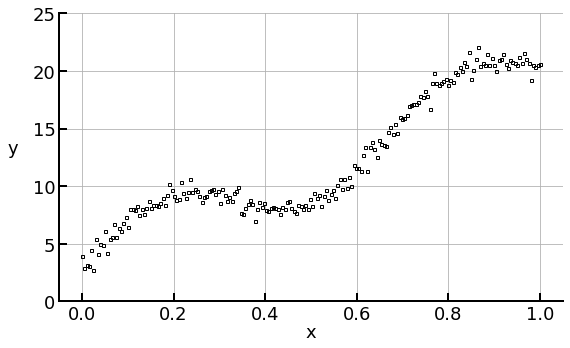

In [10]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_axes([0, 0, 1, 1])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.set_tick_params(which="major", size=8, width=2, direction="in", top=False)
ax.yaxis.set_tick_params(which="major", size=8, width=2, direction="in", top=False)

ax.plot(dfp["x"], dfp["y"], color="black", marker="s", markersize=3, markerfacecolor='none', markeredgecolor=col_data, linewidth=0)
                                                            
ax.set_xlabel("x", labelpad=0)
ax.set_ylabel("y", labelpad=20, rotation=0)
ax.set_ylim(bottom=0, top=25)

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(5))

#ax.legend()
#plt.savefig('..\\..\\Thesis_WorkingDirectory\\thesisplots\\test_func.pdf',  transparent=False, bbox_inches='tight')

### **Plot B-spline fit and basis functions**

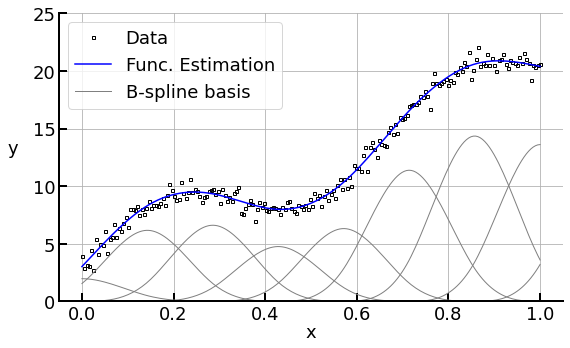

In [11]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_axes([0, 0, 1, 1])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.set_tick_params(which="major", size=8, width=2, direction="in", top=False)
ax.yaxis.set_tick_params(which="major", size=8, width=2, direction="in", top=False)

ax.plot(dfp["x"], dfp["y"], color=col_data, label="Data", marker="s", markersize=3, markerfacecolor='none', markeredgecolor=col_data, linewidth=0)
                                                            
ax.plot(dfp["x"], dfp["fit_s"], color=col_unc_fit, label="Func. Estimation")

for i in range(M_smooth.basis.shape[1]):
    ax.plot(x, M_smooth.basis[:,i]*M_smooth.coef_[i], color=col_basis_func, linewidth=1)
    if i == 0:
        ax.plot(x, M_smooth.basis[:,i]*M_smooth.coef_[i], color=col_basis_func, linewidth=1, label="B-spline basis")
        
ax.set_xlabel("x", labelpad=0)
ax.set_ylabel("y", labelpad=20, rotation=0)
ax.set_ylim(bottom=0, top=25)

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(5))

ax.legend()
#plt.savefig('..\\..\\Thesis_WorkingDirectory\\thesisplots\\smooth_bf.pdf',  transparent=False, bbox_inches='tight')

### **Plot low and high number of splines**

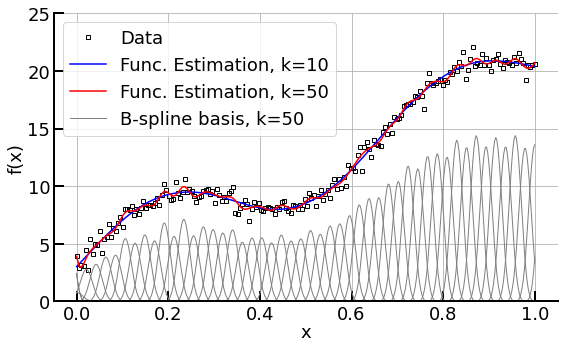

In [162]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_axes([0,0,1,1])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.set_tick_params(which="major", size=10, width=2, direction="in", top=False)
ax.yaxis.set_tick_params(which="major", size=10, width=2, direction="in", top=False)

ax.plot(dfp["x"], dfp["y"], color=col_data, label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
                                                            
ax.plot(dfp["x"], dfp["fit_s"], color=col_unc_fit, label=r"Func. Estimation, k=10")
ax.plot(dfp["x"], dfp["fit_w"], color=col_con_fit, label=r"Func. Estimation, k=50")

# create finer B-spline basis for plotting
xplot = np.linspace(0,1,400)
BS = Bspline()
BS.bspline_basis(x_data=xplot, k=M_wiggly.basis.shape[1])
for i in range(M_wiggly.basis.shape[1]):
    ax.plot(xplot, BS.basis[:,i]*M_wiggly.coef_[i], color=col_basis_func, linewidth=1)
    if i == 0:
        ax.plot(xplot, BS.basis[:,i]*M_wiggly.coef_[i], color=col_basis_func, linewidth=1, label=r"B-spline basis, k=50")
        
#ax.set_xlabel(r"$\mathregular{\lambda}$ (nm)", labelpad=0)
ax.set_xlabel("x", labelpad=0)
ax.set_ylabel("f(x)", labelpad=2)
ax.set_ylim(bottom=0, top=25)

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(5))

ax.legend()
#plt.savefig('..\\..\\Thesis_WorkingDirectory\\thesisplots\\smooth_wiggly_bf.pdf', transparent=False, bbox_inches='tight')

### **Plot P-splines for several $\lambda_s$ values**

In [20]:
n = 50
m_p_m2 = (("s(1)", "none", n, (10**-2, 0), "equidistant"),)
m_p_0 = (("s(1)", "none", n, (10**0, 0), "equidistant"),)
m_p_2 = (("s(1)", "none", n, (10**2, 0), "equidistant"),)
m_p_5 = (("s(1)", "none", n, (10**5, 0), "equidistant"),)
m_p_6 = (("s(1)", "none", n, (10**6, 0), "equidistant"),)
m_p_8 = (("s(1)", "none", n, (10**8, 0), "equidistant"),) 


M_p_m2 = StarModel(description=m_p_m2).fit(X=df["x"].values.reshape(-1,1), y=df["y"].values, plot_=0, verbose=False)
M_p_0 = StarModel(description=m_p_0).fit(X=df["x"].values.reshape(-1,1), y=df["y"].values, plot_=0, verbose=False)
M_p_2 = StarModel(description=m_p_2).fit(X=df["x"].values.reshape(-1,1), y=df["y"].values, plot_=0, verbose=False)
M_p_5 = StarModel(description=m_p_4).fit(X=df["x"].values.reshape(-1,1), y=df["y"].values, plot_=0, verbose=False)
M_p_6 = StarModel(description=m_p_6).fit(X=df["x"].values.reshape(-1,1), y=df["y"].values, plot_=0, verbose=False)
M_p_8 = StarModel(description=m_p_8).fit(X=df["x"].values.reshape(-1,1), y=df["y"].values, plot_=0, verbose=False)

ypred_p_m2 = M_p_m2.basis @ M_p_m2.coef_
ypred_p_0 = M_p_0.basis @ M_p_0.coef_
ypred_p_2 = M_p_2.basis @ M_p_2.coef_
ypred_p_5 = M_p_4.basis @ M_p_4.coef_
ypred_p_6 = M_p_6.basis @ M_p_6.coef_
ypred_p_8 = M_p_8.basis @ M_p_8.coef_

df_ps = pd.DataFrame(data={"x":x, "y":y, "yp_m2":ypred_p_m2, "yp_0":ypred_p_0, "yp_2":ypred_p_2, "yp_5":ypred_p_5, "yp_6":ypred_p_6, "yp_8":ypred_p_8 })

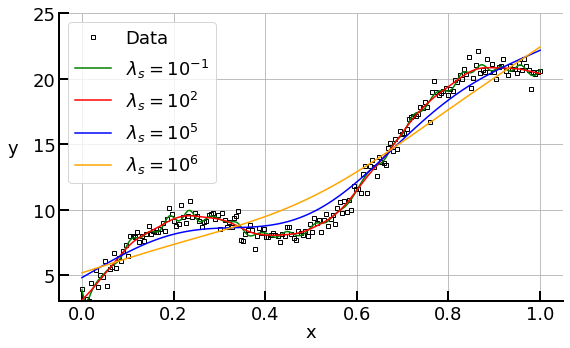

In [24]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_axes([0,0,1,1])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.set_tick_params(which="major", size=10, width=2, direction="in", top=False)
ax.yaxis.set_tick_params(which="major", size=10, width=2, direction="in", top=False)

ax.plot(df_ps["x"], df_ps["y"], color=col_data, label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)                                                            
ax.plot(df_ps["x"], df_ps["yp_m2"], color="green", label=r"$\lambda_s = 10^{-1}$")
ax.plot(df_ps["x"], df_ps["yp_2"], color="red", label=r"$\lambda_s = 10^{2}$")
ax.plot(df_ps["x"], df_ps["yp_5"], color="blue", label=r"$\lambda_s = 10^{5}$")
ax.plot(df_ps["x"], df_ps["yp_6"], color="orange", label=r"$\lambda_s = 10^{6}$")

       
#ax.set_xlabel(r"$\mathregular{\lambda}$ (nm)", labelpad=0)
ax.set_xlabel("x", labelpad=0)
ax.set_ylabel("y", labelpad=20, rotation=0)
ax.set_ylim(bottom=3, top=25)

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(5))

ax.legend()
plt.savefig('..\\..\\Thesis_WorkingDirectory\\thesisplots\\p_splines.pdf', transparent=False, bbox_inches='tight')

## **Monotonicity constraint fit**

{'s(1)': {'constraint': 'none',
          'knot_type': 'equidistant',
          'lam': {'constraint': 271858.824273294,
                  'smoothness': 271.85882427329403},
          'n_param': 30}}


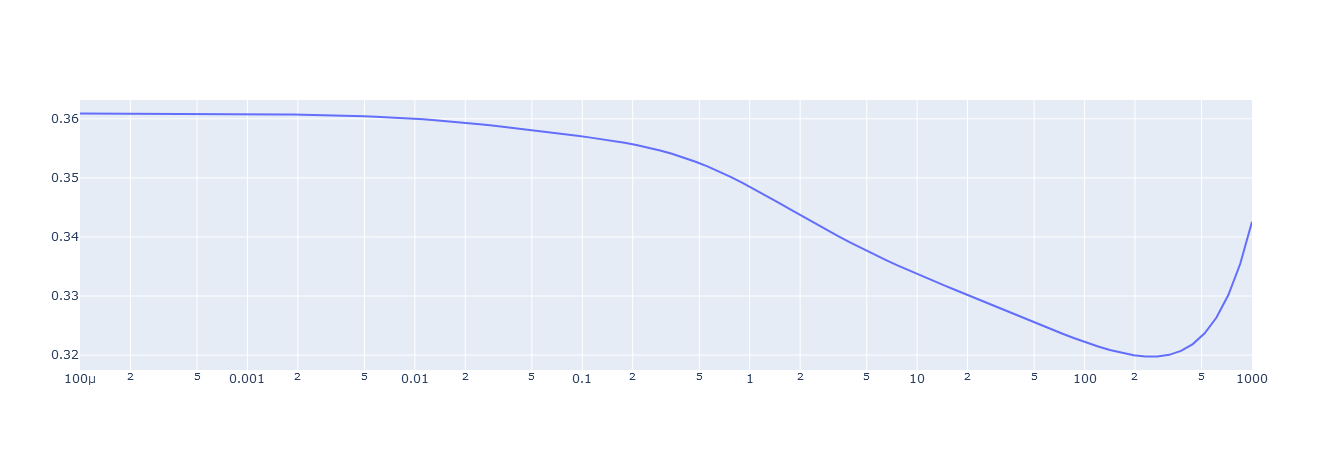

In [32]:
n = 30
m_base = (("s(1)", "none", n, (0.1, 0), "equidistant"),)
m_c = (("s(1)", "inc", n, (0.1, 6000), "equidistant"),)

Mbase = StarModel(description=m_base)
Mcon = StarModel(description=m_c)

Mbase.GCV_smoothingParameter(X=df["x"].values.reshape(-1,1), y=df["y"], n_grid=100)
print(Mbase)
Mbase.plot_GCV_curve()
best_lam_s = Mbase.description_dict["s(1)"]["lam"]["smoothness"]
m_c = (("s(1)", "inc", n, (best_lam_s, 6000), "equidistant"),)
Mcon = StarModel(description=m_c)

In [35]:
Mbase.fit(X=df["x"].values.reshape(-1,1), y=df["y"].values, plot_=0)
Mcon.fit(X=df["x"].values.reshape(-1,1), y=df["y"].values, plot_=0)

ypred_b = Mbase.basis @ Mbase.coef_
ypred_c = Mcon.basis @ Mcon.coef_

df_c = pd.concat((df, pd.DataFrame(data={"yp_b":ypred_b, "yp_c":ypred_c})), axis=1)

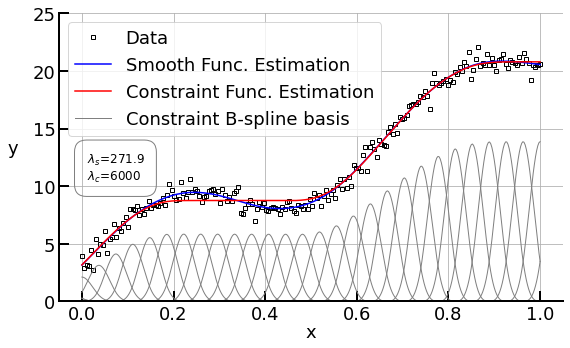

In [76]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_axes([0,0,1,1])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.set_tick_params(which="major", size=10, width=2, direction="in", top=False)
ax.yaxis.set_tick_params(which="major", size=10, width=2, direction="in", top=False)

ax.plot(x, y, color=col_data, label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
                                                            
ax.plot(x, df_c["yp_b"], color=col_unc_fit, label="Smooth Func. Estimation")
ax.plot(x, df_c["yp_c"], color=col_con_fit, label="Constraint Func. Estimation")

# create finer B-spline basis for plotting
xplot = np.linspace(0,1,400)
BS = Bspline()
BS.bspline_basis(x_data=xplot, k=Mcon.basis.shape[1])
for i in range(Mcon.basis.shape[1]):
    ax.plot(xplot, BS.basis[:,i]*Mcon.coef_[i], color="grey", linewidth=1)
    if i == 0:
        ax.plot(xplot, BS.basis[:,i]*Mcon.coef_[i], color="grey", linewidth=1, label="Constraint B-spline basis")
        
#ax.set_xlabel(r"$\mathregular{\lambda}$ (nm)", labelpad=0)
ax.set_xlabel("x", labelpad=0)
ax.set_ylabel("y", labelpad=20, rotation=0)
ax.set_ylim(bottom=0, top=25)

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(5))

ax.text(x=0.01, y=10.50, s=r"$\lambda_s$="+str(round(best_lam_s, 1))+"\n"+r"$\lambda_c$="+str(6000), fontsize=12, color='black', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))

ax.legend()

#plt.savefig('..\\..\\Thesis_WorkingDirectory\\thesisplots\\inc_spline.pdf', transparent=False, bbox_inches='tight')

### **Peak Finding For Unimodality Constraint**

In [134]:
np.random.seed(2)
x = np.linspace(0,1,100)
y = np.exp(-(x-0.4)**2/ 0.01)
noise = np.random.normal(scale=0.05, size=len(x))
yn = y+noise
k = 15
idx_max = np.argmax(yn)
yn[idx_max] += 0.1

B = Bspline()
B.bspline_basis(x_data=x, k=k)

In [135]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x,y=yn, mode="markers"))
for i in range(B.basis.shape[1]):
    fig.add_trace(go.Scatter(x=x, y=B.basis[:,i], mode="lines"))
fig.add_trace(go.Scatter(x=[x[idx_max]], y=[yn[idx_max]]))
fig.show()

border = np.argwhere(B.basis[idx_max,:] > 0)

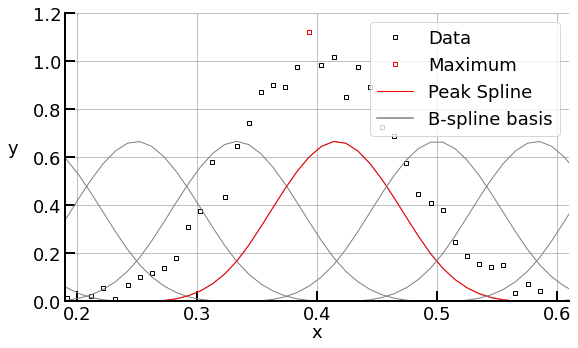

In [175]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_axes([0,0,1,1])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.set_tick_params(which="major", size=10, width=2, direction="in", top=False)
ax.yaxis.set_tick_params(which="major", size=10, width=2, direction="in", top=False)

ax.plot(x, yn, color=col_data, label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax.plot(x[idx_max], yn[idx_max], label="Maximum", marker="s", markersize=4, markerfacecolor="none", markeredgecolor="red", linewidth=0)                                                       
# create finer B-spline basis for plotting
for i in range(B.basis.shape[1]):
    ax.plot(x, B.basis[:,i], color="grey", linewidth=1)
    if i == border[-2][0]:
        ax.plot(x, B.basis[:,i], color="red", linewidth=1, label="Peak Spline")

ax.plot(0,0, color="grey", label="B-spline basis")
#ax.set_xlabel(r"$\mathregular{\lambda}$ (nm)", labelpad=0)
ax.set_xlabel("x", labelpad=0)
ax.set_ylabel("y", labelpad=20, rotation=0)
ax.set_ylim(bottom=0, top=1.2)
ax.set_xlim(left=0.19, right=0.61)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.legend()

#plt.savefig('..\\..\\Thesis_WorkingDirectory\\thesisplots\\peak_spline.pdf', transparent=False, bbox_inches='tight')

## **2D Test Function**

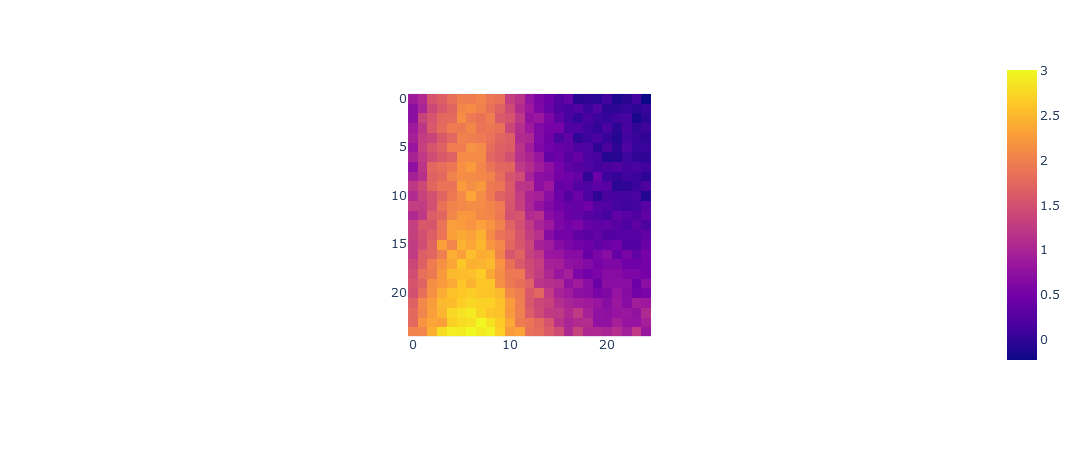

In [2]:
n = 25
x1, x2 = np.linspace(0,1,n), np.linspace(0,1,n)
x1g, x2g = np.meshgrid(x1, x2)
X = np.vstack((x1g.ravel(), x2g.ravel())).T
def f(x1, x2):
    return 2*np.exp(-((x1 - 0.25)**2/0.08)) + x2**2 + np.random.normal(loc=0.0, scale=0.1, size=x1.shape)
y2d = f(X[:,0], X[:,1])
df = {"x1":X[:,0], "x2":X[:,1], "y":y2d}
px.imshow(y2d.reshape(25,25))

In [3]:
m = ( ("s(1)", "peak", 50, (1, 6000), "equidistant"),
       ("s(2)", "inc", 50, (1, 6000), "equidistant"),
    )
M = StarModel(description=m)
M.fit(X=X, y=y2d, plot_=0, verbose=False, max_iter=5)

StarModel(s(1)={'constraint': 'peak', 'knot_type': 'equidistant',
                'lam': {'constraint': 6000, 'smoothness': 1}, 'n_param': 50},
          s(2)={'constraint': 'inc', 'knot_type': 'equidistant',
                'lam': {'constraint': 6000, 'smoothness': 1}, 'n_param': 50})

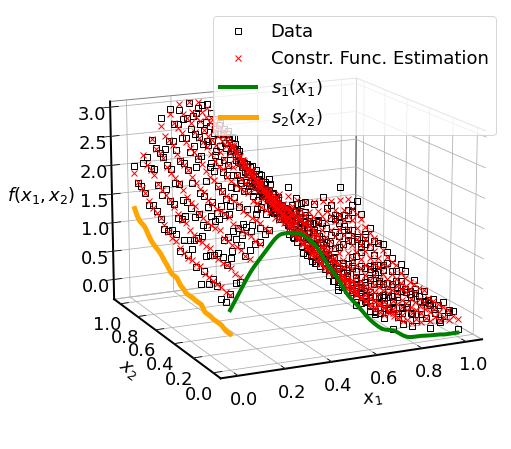

In [12]:
fig = plt.figure(figsize=(14,8))
ax = fig.gca(projection='3d')

ax.grid(True)
ax.xaxis.pane.set_edgecolor("black")
ax.yaxis.pane.set_edgecolor("black")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(elev=15, azim=135+110)

ax.xaxis._axinfo["tick"]["inward_factor"] = 0
ax.xaxis._axinfo["tick"]["outward_factor"] = 0.4
ax.yaxis._axinfo["tick"]["inward_factor"] = 0
ax.yaxis._axinfo["tick"]["outward_factor"] = 0.4
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.4
ax.zaxis._axinfo["tick"]["outward_factor"] = 0.4
ax.zaxis._axinfo["tick"]["outward_factor"] = 0.4

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.zaxis.set_major_locator(MultipleLocator(0.5))

ax.plot(xs=X[:,0], ys=X[:,1], zs=y2d, marker="s", label="Data", color=col_data, markersize=6, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax.plot(xs=X[:,0], ys=X[:,1], zs=M.basis@M.coef_, label="Constr. Func. Estimation", marker="x", color=col_con_fit, markersize=6, markerfacecolor='none', markeredgecolor="red", linewidth=0)

ax.set_xlabel(r"$x_1$", labelpad=10)
ax.set_ylabel(r"$x_2$", labelpad=10)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r"$f(x_1,x_2)$", labelpad=25, rotation=0)

xplot, B = np.linspace(0,1,200), Bspline()
B.bspline_basis(x_data=xplot, k=50)
ax.plot(xs=xplot, ys=np.zeros(200), zs=B.basis@M.smooths["s(1)"].coef_, linewidth=4, label=r"$s_1(x_1)$", color="green")
ax.plot(xs=np.zeros(200), ys=xplot, zs=B.basis@M.smooths["s(2)"].coef_, linewidth=5, label=r"$s_2(x_2)$", color="orange")
#ax.plot(xs=x1g.ravel(), ys=x2g.ravel(), zs=M.smooths["t(1,2)"].basis@M.smooths["t(1,2)"].coef_)

#ax.legend(bbox_to_anchor=(0.995, 0.685), loc="upper right", frameon=False, fontsize=16)
ax.legend()
plt.savefig('..\\..\\Thesis_WorkingDirectory\\thesisplots\\2d_example.pdf', transparent=False, bbox_inches='tight')

### **Linear and quadratic Splines**

In [2]:
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from stareg.bspline import Bspline

x = np.linspace(0,1,1000)
Blin, Bquad, Bcubic = Bspline(), Bspline(), Bspline()
Blin.bspline_basis(x_data=x, k=10, m=0, type_="equidistant")
Bquad.bspline_basis(x_data=x, k=10, m=1, type_="equidistant")
Bcubic.bspline_basis(x_data=x, k=10, m=2)

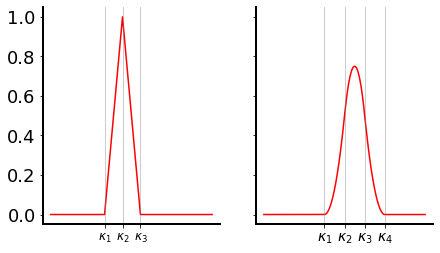

In [7]:
# Create two subplots 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7,4))
# Customized the left plot
ax1.plot(x, Blin.basis[:,6], color="red", label=r"Spline")
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.axvline(Blin.knots[6], 0, 1, color="grey", alpha=0.4, linewidth=1)
ax1.axvline(Blin.knots[7], 0, 1, color="grey", alpha=0.4, linewidth=1)
ax1.axvline(Blin.knots[8], 0, 1, color="grey", alpha=0.4, linewidth=1)
ax1.set_xticks([Blin.knots[6], Blin.knots[7], Blin.knots[8]])
ax1.set_xticklabels([r"$\kappa_1$", r"$\kappa_2$", r"$\kappa_3$"], size=12)

# Customize the right plot
ax2.plot(x, Bquad.basis[:,6], color="red", label=r"Spline")
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.axvline(Bquad.knots[6], 0, 1, color="grey", alpha=0.4, linewidth=1)
ax2.axvline(Bquad.knots[7], 0, 1, color="grey", alpha=0.4, linewidth=1)
ax2.axvline(Bquad.knots[8], 0, 1, color="grey", alpha=0.4, linewidth=1)
ax2.axvline(Bquad.knots[9], 0, 1, color="grey", alpha=0.4, linewidth=1)
ax2.set_xticks([Bquad.knots[6],Bquad.knots[7],Bquad.knots[8], Bquad.knots[9]])
ax2.set_xticklabels([r"$\kappa_1$", r"$\kappa_2$", r"$\kappa_3$", r"$\kappa_4$"], size=14)

ax1.grid(b=False)
ax2.grid(b=False)
# plt.savefig('..\\..\\Thesis_WorkingDirectory\\thesisplots\\linear_and_quadratic_spline.pdf', transparent=False, bbox_inches='tight')

## **STATIC FUNCTION FITTING 1** 

In [39]:
np.random.seed(1)
# generate some data
n = 100
x = np.linspace(0,1,n)
knick = 0.45
noise = np.random.normal(loc=0.0, scale=0.05, size=n)

y = f1(x, knick=knick) 
yn = y + noise 

df = pd.DataFrame(data=dict(x=x, y=y, yn=yn))

# train-test split
cont = True
while cont:
    
    df_train, df_test = train_test_split(df, test_size=0.25, shuffle=True)
    df_train = df_train.sort_index()
    df_test = df_test.sort_index()
    print("Train Test Split")
    if df_train.min()["x"]==0 and df_train.max()["x"]==1:
        cont = False
        print("Finished")

Train Test Split
Train Test Split
Train Test Split
Train Test Split
Train Test Split
Finished


### **Data**

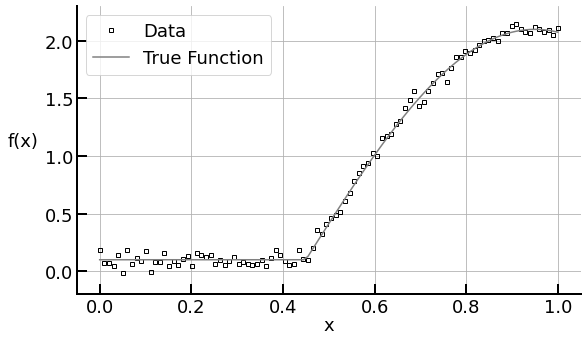

In [40]:
# plot the data
fig = plt.figure(figsize=small_fig_size)
ax = fig.add_axes([0,0,1,1])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.set_tick_params(which="major", size=10, width=2, direction="in", top=False)
ax.yaxis.set_tick_params(which="major", size=10, width=2, direction="in", top=False)

ip = 1
ax.plot(df["x"][::ip], df["yn"][::ip], color=col_data, label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax.plot(df["x"][::ip], df["y"][::ip], color=col_basis_func, label="True Function", linestyle="-")
 
#ax.set_xlabel(r"$\mathregular{\lambda}$ (nm)", labelpad=0)
ax.set_xlabel("x", labelpad=0)
ax.set_ylabel("f(x)", labelpad=22, rotation=0)
ax.set_ylim(bottom=-0.2, top=2.3)
ax.legend()

path = "..\\..\\Thesis_WorkingDirectory\\thesisplots\\"
fname = "exp_inc1_data"
# plt.savefig(path+fname+".pdf", transparent=False, bbox_inches='tight')

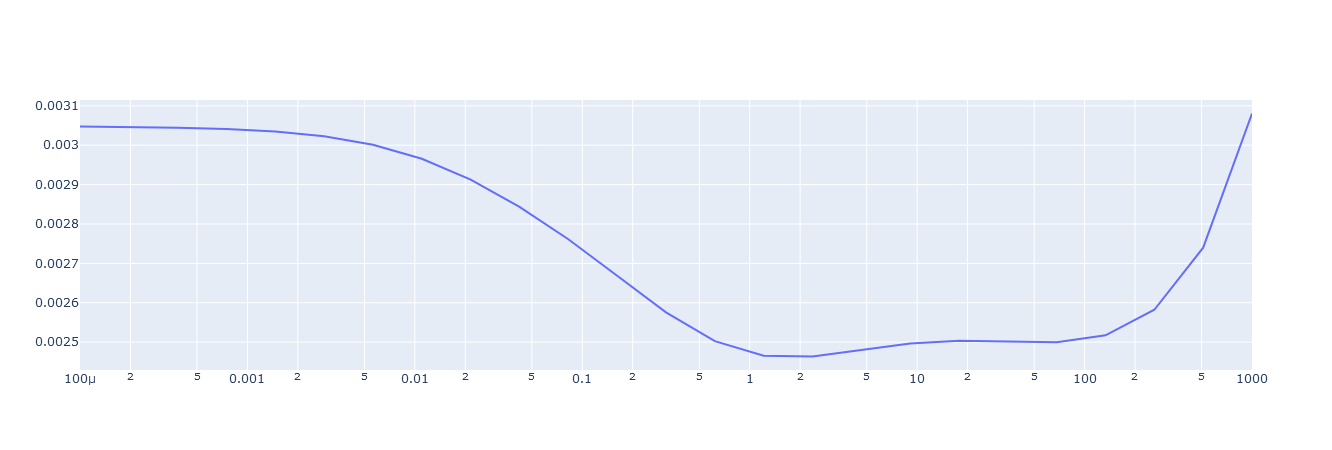

Best smoothing paramter found is {'smoothness': 2.371373705661655, 'constraint': 2371.373705661655}
M_con:  {'s(1)': {'constraint': 'inc',
          'knot_type': 'equidistant',
          'lam': {'constraint': 2371.373705661655,
                  'smoothness': 2.371373705661655},
          'n_param': 35}}
--------------------------------------------------
MSE unconstraint on noisy samples:  0.00123113
MSE constraint on noisy samples:    0.00162438
--------------------------------------------------
MSE unconstraint on true function:  0.00049133
MSE constraint on true function:    0.0003205
--------------------------------------------------
MSE unconstraint on test set:       0.00062156
MSE constraint on test set:         0.00026096
--------------------------------------------------
AIC unconstraint:                   -85.77104354061446
AIC constraint:                     -157.53449564325007


In [41]:
# Unconstraint Model
m_unc = (("s(1)", "none", 35, (1, 0), "equidistant"),)
M_unc = StarModel(description=m_unc)
M_unc.GCV_smoothingParameter(X=df_train["x"].values.reshape(-1,1), y=df_train["yn"], n_grid=25)
M_unc.plot_GCV_curve()
best_lam_s = M_unc.smooths["s(1)"].lam["smoothness"]
print(f"Best smoothing paramter found is {M_unc.smooths['s(1)'].lam}")
yfit_unc = M_unc.basis @ M_unc.coef_

B = Bspline()
B.bspline_basis(x_data=df_test["x"].values, k=M_unc.coef_list[-1])
ypred_unc = B.basis @ M_unc.coef_


# Constraint Model
m = (("s(1)", "inc", 35, (best_lam_s, best_lam_s*1000), "equidistant"), )
M_con = StarModel(description=m)

M_con.fit(X=df_train["x"].values.reshape(-1,1), y=df_train["yn"], plot_=False)
yfit_con = M_con.basis @ M_con.coef_
print("M_con: ", M_con)
B = Bspline()
B.bspline_basis(x_data=df_test["x"].values, k=M_con.coef_list[-1])
ypred_con = B.basis @ M_con.coef_

print("".center(50, "-"))
print("MSE unconstraint on noisy samples: ".ljust(35), mean_squared_error(df_train["yn"], yfit_unc).round(8))
print("MSE constraint on noisy samples: ".ljust(35), mean_squared_error(df_train["yn"], yfit_con).round(8))
print("".center(50, "-"))
print("MSE unconstraint on true function: ".ljust(35), mean_squared_error(df_train["y"], yfit_unc).round(8))
print("MSE constraint on true function: ".ljust(35), mean_squared_error(df_train["y"], yfit_con).round(8))
print("".center(50, "-"))
print("MSE unconstraint on test set: ".ljust(35), mean_squared_error(df_test["y"], M_unc.predict(X=df_test["x"].values.reshape(-1,1))).round(8))
print("MSE constraint on test set: ".ljust(35), mean_squared_error(df_test["y"], M_con.predict(X=df_test["x"].values.reshape((-1,1)))).round(8))
print("".center(50, "-"))
print("AIC unconstraint: ".ljust(35), AIC(model=M_unc, ytest=df_test["y"], Xtest=df_test["x"].values.reshape((-1,1))))
print("AIC constraint: ".ljust(35), AIC(model=M_con, ytest=df_test["y"], Xtest=df_test["x"].values.reshape((-1,1))))

### **Constrained and Unconstrained Fit**

Plot the constrained and unconstraint fit for Function 1


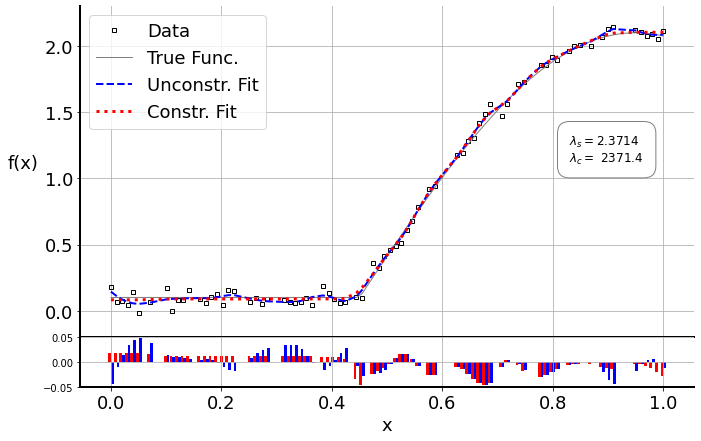

In [7]:
print("Plot the constrained and unconstraint fit for Function 1")
fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=large_fig_size,
                      gridspec_kw={"hspace": 0, "height_ratios":[1,0.15]},
                     constrained_layout=False)
ax1, ax2 = axs

for ax in axs.ravel():
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
# remove the tick labels for the constraint violation plot
# plot data
ip = 1
ax1.plot(df_train["x"][::ip], df_train["yn"][::ip], color="black", label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax1.plot(df["x"], df["y"], color="grey", linestyle="-", label="True Func.", linewidth=1)                         
ax1.plot(df_train["x"], yfit_unc, color="blue", label="Unconstr. Fit", linestyle="--", linewidth=2)
ax1.plot(df_train["x"], yfit_con, color="red", label="Constr. Fit", linestyle=":", linewidth=3)

ax1.set_ylim(bottom=-0.2, top=2.3)

lambda_s = r"$\lambda_s ={}$".format(round(M_con.smooths["s(1)"].lam["smoothness"], 4))  
lambda_c = r"$\lambda_c =$ {}".format(round(M_con.smooths["s(1)"].lam["constraint"], 1))
ax1.text(x=0.83, y=1.125, s=lambda_s+"\n"+lambda_c, fontsize=12, color='black', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))


###############################################################################################
# residual plot
###############################################################################################
# calculate the residuals
residual_con = (df_train["y"] - yfit_con).values # / df_train["y"]
residual_unc = (df_train["y"] - yfit_unc).values # / df_train["y"]

bar_width = 0.01

ax2.tick_params(axis='y', labelsize=10)
ax2.set_ylim(bottom=-1.2*max(abs(residual_con)), top=1.2*max(abs(residual_con)))
ax2.set_ylim(bottom=-0.05, top=0.05)

ax2.bar(x=df_train["x"]-bar_width/4, color="red", 
         height=residual_con, width=bar_width/2)
ax2.bar(x=df_train["x"]+bar_width/4, color="blue", 
         height=residual_unc, width=bar_width/2)
ax2.set_xlabel("x")

ax1.set_ylabel("f(x)", rotation=0, labelpad=22)
ax1.legend()

path = "..\\..\\Thesis_WorkingDirectory\\thesisplots\\"
fname = "exp_inc1_fit"
#fig.savefig(path+fname+".pdf", transparent=False, bbox_inches='tight')

In [67]:
max(abs(residual_con))


0.08928035058386367

## **STATIC FUNCTION FITTING 2  -- Gauss + Linear**

In [2]:
# generate noisy data
np.random.seed(1)

n = 500
x = np.linspace(0,1,n)
noise = np.random.normal(loc=0.0, scale=0.1, size=n)

ydata_gen = f2(x)
yn = f2(x) + noise
ytrue = f2_true(x)

df = pd.DataFrame(data=dict(x=x, y=ytrue, yn=yn, ydata_gen=ydata_gen))

### **Data**

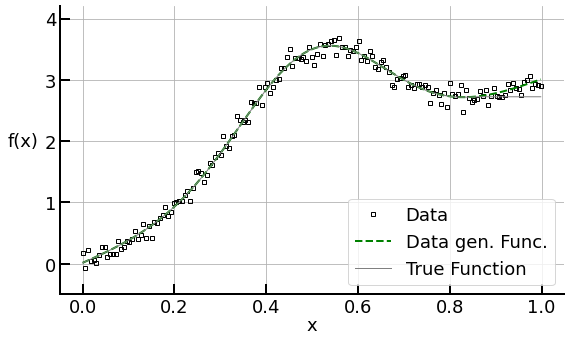

In [3]:
# plot the data
fig = plt.figure(figsize=small_fig_size)
ax = fig.add_axes([0,0,1,1])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.set_tick_params(which="major", size=10, width=2, direction="in", top=False)
ax.yaxis.set_tick_params(which="major", size=10, width=2, direction="in", top=False)

ip = 3
ax.plot(df["x"][::ip], df["yn"][::ip], color=col_data, label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax.plot(df["x"][::ip], df["ydata_gen"][::ip], color="green", label="Data gen. Func.", linestyle="--", linewidth=2)
ax.plot(df["x"][::ip], df["y"][::ip], color=col_basis_func, label="True Function", linestyle="-", linewidth=1)

#ax.set_xlabel(r"$\mathregular{\lambda}$ (nm)", labelpad=0)
ax.set_xlabel("x", labelpad=0)
ax.set_ylabel("f(x)", labelpad=22, rotation=0)
ax.set_ylim(bottom=-0.5, top=4.2)
ax.legend()

path = "..\\..\\Thesis_WorkingDirectory\\thesisplots\\"
fname = "exp_peak_data"
#plt.savefig(path+fname+".pdf", transparent=False, bbox_inches='tight')

In [7]:
# train-test split
cont = True
while cont:
    
    df_train, df_test = train_test_split(df, test_size=0.25, shuffle=True)
    df_train = df_train.sort_index()
    df_test = df_test.sort_index()
    print("Train Test Split")
    if df_train.min()["x"]==0 and df_train.max()["x"]==1:
        cont = False
        print("Finished")

Train Test Split
Train Test Split
Finished


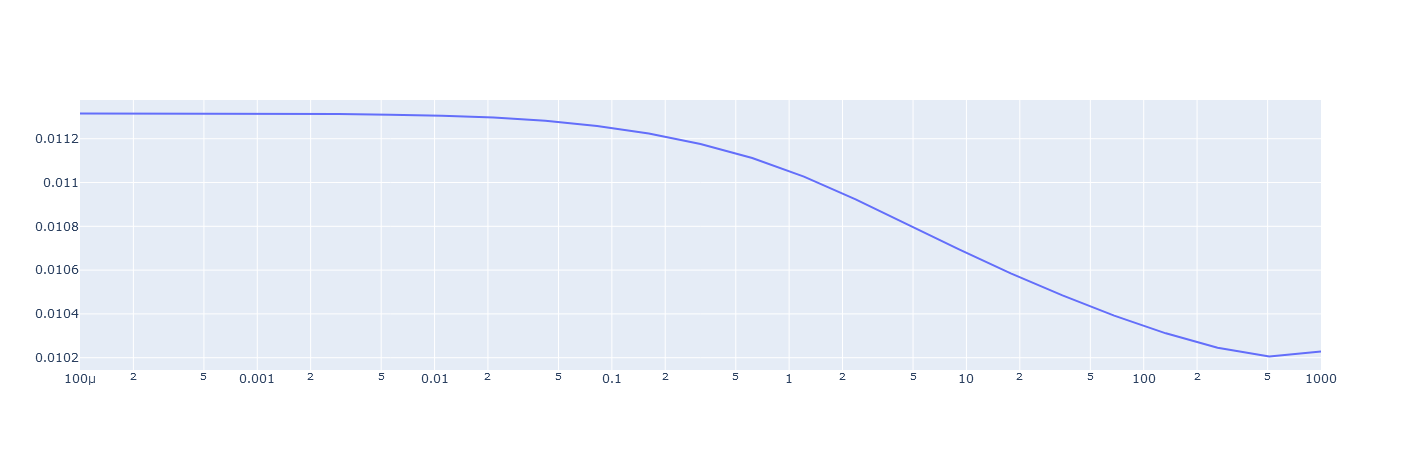

Best smoothing paramter found is {'smoothness': 510.89697745069344, 'constraint': 510896.97745069343}


In [9]:
# Unconstraint Model
m_unc = (("s(1)", "none", 35, (1, 1000), "equidistant"),)
M_unc = StarModel(description=m_unc)
M_unc.GCV_smoothingParameter(X=df_train["x"].values.reshape(-1,1), y=df_train["yn"], n_grid=25)
M_unc.plot_GCV_curve()
best_lam_s = M_unc.smooths["s(1)"].lam["smoothness"]
print(f"Best smoothing paramter found is {M_unc.smooths['s(1)'].lam}")
yfit_unc = M_unc.basis @ M_unc.coef_

B = Bspline()
B.bspline_basis(x_data=df_test["x"].values, k=M_unc.coef_list[-1])
ypred_unc = B.basis @ M_unc.coef_

In [29]:
# Constraint Model peak
m = (("s(1)", "peak", 35, (best_lam_s, best_lam_s*10), "equidistant"), )
#m = (("s(1)", "peak", 35, (0.6189, 6189), "equidistant"), )
M_con_peak = StarModel(description=m)

M_con_peak.fit(X=df_train["x"].values.reshape(-1,1), y=df_train["yn"], plot_=False)
yfit_con_peak = M_con_peak.basis @ M_con_peak.coef_
print("M_con_peak:", M_con_peak)
B = Bspline()
B.bspline_basis(x_data=df_test["x"].values, k=M_con_peak.coef_list[-1])
ypred_con_peak = B.basis @ M_con_peak.coef_


# Constraint Model concave
m = (("s(1)", "conc", 35, (best_lam_s, best_lam_s*10), "equidistant"), )
#m = (("s(1)", "conc", 35, (0.6189, 6189), "equidistant"), )
M_con_concave = StarModel(description=m)

M_con_concave.fit(X=df_train["x"].values.reshape(-1,1), y=df_train["yn"], plot_=False)
yfit_con_concave = M_con_concave.basis @ M_con_concave.coef_
print("M_con_concave: ", M_con_concave)
B = Bspline()
B.bspline_basis(x_data=df_test["x"].values, k=M_con_concave.coef_list[-1])
ypred_con_concave = B.basis @ M_con_concave.coef_


print("".center(50, "-"))
print("MSE unconstraint on noisy samples: ".ljust(42), mean_squared_error(df_train["y"], yfit_unc).round(8))
print("MSE concave constraint on noisy samples: ".ljust(42), mean_squared_error(df_train["y"], yfit_con_concave).round(8))
print("MSE peak constraint on noisy samples: ".ljust(42), mean_squared_error(df_train["y"], yfit_con_peak).round(8))
print("".center(50, "-"))
print("MSE unconstraint on true function: ".ljust(42), mean_squared_error(df_train["y"], yfit_unc).round(8))
print("MSE concave constraint on true function: ".ljust(42), mean_squared_error(df_train["y"], yfit_con_concave).round(8))
print("MSE peak constraint on true function: ".ljust(42), mean_squared_error(df_train["y"], yfit_con_peak).round(8))
print("".center(50, "-"))
print("MSE unconstraint on test set: ".ljust(42), mean_squared_error(df_test["y"], ypred_unc).round(8))
print("MSE concave constrait on test set: ".ljust(42), mean_squared_error(df_test["y"], ypred_con_concave).round(8))
print("MSE peak constrait on test set: ".ljust(42), mean_squared_error(df_test["y"], ypred_con_peak).round(8))
print("".center(50, "-"))
print("AIC unconstraint: ".ljust(35), AIC(model=M_unc, ytest=df_test["y"], Xtest=df_test["x"].values.reshape((-1,1))))
print("AIC concave: ".ljust(35), AIC(model=M_con_concave, ytest=df_test["y"], Xtest=df_test["x"].values.reshape((-1,1))))
print("AIC peak: ".ljust(35), AIC(model=M_con_peak, ytest=df_test["y"], Xtest=df_test["x"].values.reshape((-1,1))))

M_con_peak: {'s(1)': {'constraint': 'peak',
          'knot_type': 'equidistant',
          'lam': {'constraint': 5108.969774506934,
                  'smoothness': 510.89697745069344},
          'n_param': 35}}
M_con_concave:  {'s(1)': {'constraint': 'conc',
          'knot_type': 'equidistant',
          'lam': {'constraint': 5108.969774506934,
                  'smoothness': 510.89697745069344},
          'n_param': 35}}
--------------------------------------------------
MSE unconstraint on noisy samples:         0.00383952
MSE concave constraint on noisy samples:   0.01756366
MSE peak constraint on noisy samples:      0.00340002
--------------------------------------------------
MSE unconstraint on true function:         0.00383952
MSE concave constraint on true function:   0.01756366
MSE peak constraint on true function:      0.00340002
--------------------------------------------------
MSE unconstraint on test set:              0.05664126
MSE concave constrait on test set:       

### **Constrained and Unconstrained Fit**

Plot the constrained and unconstraint fit for Function 2


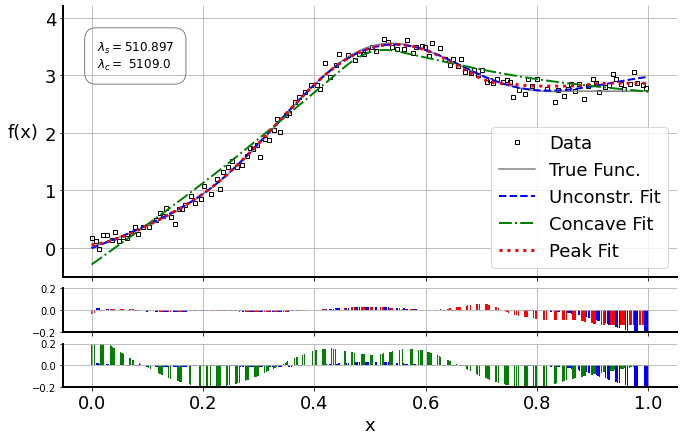

In [28]:
print("Plot the constrained and unconstraint fit for Function 2")
f, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=large_fig_size,
                      gridspec_kw={"hspace": 0.1,  "height_ratios":[1,0.16, 0.16]},
                     constrained_layout=False)
ax1, ax2, ax3 = axs

for ax in axs.ravel():
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
# remove the tick labels for the constraint violation plot
# plot data
ip = 3
ax1.plot(df_train["x"][::ip], df_train["yn"][::ip], color="black", label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax1.plot(df_train["x"], df_train["y"], color="grey", label="True Func.", linewidth=1.5)
ax1.plot(df_train["x"], yfit_unc, color="blue", label="Unconstr. Fit", linestyle="--", linewidth=2)
ax1.plot(df_train["x"], yfit_con_concave, color="green", label="Concave Fit", linestyle="-.", linewidth=2)
ax1.plot(df_train["x"], yfit_con_peak, color="red", label="Peak Fit", linestyle=":", linewidth=3)

ax1.set_ylim(bottom=-0.5, top=4.2)

lambda_s = r"$\lambda_s ={}$".format(round(M_con_peak.smooths["s(1)"].lam["smoothness"], 4))  
lambda_c = r"$\lambda_c =$ {}".format(round(M_con_peak.smooths["s(1)"].lam["constraint"], 1))
ax1.text(x=0.009, y=3.125, s=lambda_s+"\n"+lambda_c, fontsize=12, color='black', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))

###############################################################################################
# residual plot
###############################################################################################
xplot = np.linspace(0,1,100)
yplot = f2_true(xplot)
# calculate the predictions on the finer grid
B = Bspline()
B.bspline_basis(x_data=xplot, k=M_unc.coef_list[-1])
ypred_unc_plot = B.basis @ M_unc.coef_
B = Bspline()
B.bspline_basis(x_data=xplot, k=M_con_peak.coef_list[-1])
ypred_con_peak_plot = B.basis @ M_con_peak.coef_
B = Bspline()
B.bspline_basis(x_data=xplot, k=M_con_concave.coef_list[-1])
ypred_con_concave_plot = B.basis @ M_con_concave.coef_
# calculate the residuals
residual_con_peak = (df_train["y"] - yfit_con_peak)
residual_con_concave = (df_train["y"] - yfit_con_concave)
residual_unc = (df_train["y"] - yfit_unc) 

max_ticks = 1.4*max([max(abs(residual_unc)), max(abs(residual_con_peak)), max(abs(residual_con_concave))])
bar_width = 0.002

# plot residuals for peak fit vs unconstrained fit
ax2.tick_params(axis='y', labelsize=10)
ax2.set_ylim(bottom=-0.2, top=0.2)
ax2.bar(x=df_train["x"]-bar_width/4, color="red", height=residual_con_peak, width=bar_width/2)
ax2.bar(x=df_train["x"]+bar_width/4, color="blue",height=residual_unc, width=bar_width/2)


# plot residuals for concave fit vs unconstrained fit
ax3.tick_params(axis='y', labelsize=10)
ax3.set_ylim(bottom=-0.2, top=0.2)
ax3.bar(x=df_train["x"]-bar_width/4, color="green", height=residual_con_concave, width=bar_width/2)
ax3.bar(x=df_train["x"]+bar_width/4, color="blue",height=residual_unc, width=bar_width/2)

# legend
ax1.legend()
ax3.set_xlabel("x")
ax1.set_ylabel("f(x)", rotation=0, labelpad=22)
path = "..\\..\\Thesis_WorkingDirectory\\thesisplots\\"
fname = "exp_peak_fit"
# plt.savefig(path+fname+".pdf", transparent=False, bbox_inches='tight')

## **Constraint vs. Noise**

## **Noise Levels**

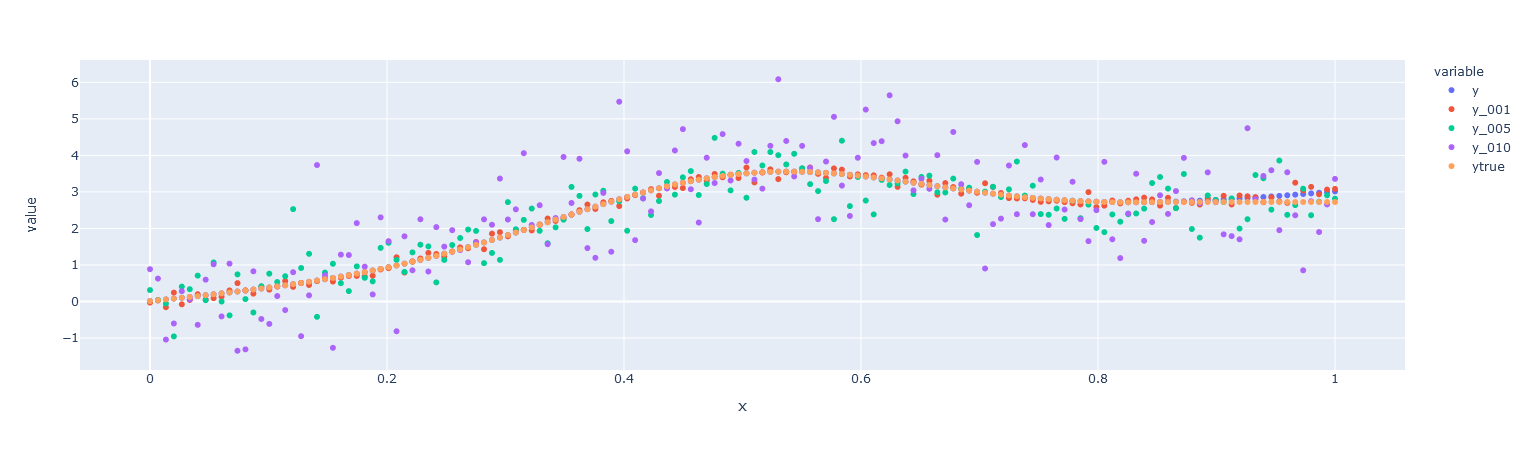

In [4]:
np.random.seed(2)
n = 150
x = np.linspace(0,1,n)

noise_01 = np.random.normal(loc=0.0, scale=0.1, size=n)
noise_05 = np.random.normal(loc=0.0, scale=0.5, size=n)
noise_1  = np.random.normal(loc=0.0, scale=1, size=n)

y = f2(x)
ytrue = f2_true(x)

df = pd.DataFrame(data=dict(x=x, y=y, ytrue=ytrue, y_001=y+noise_01, y_005=y+noise_05, y_010=y+noise_1))
px.scatter(df, x="x", y=["y", "y_001", "y_005", "y_010", "ytrue"], width=10)

In [5]:
# train-test split
cont = True
while cont:
    print("Train-Test-Split")
    df_train, df_test = train_test_split(df, test_size=0.25, shuffle=True)
    df_train = df_train.sort_index()
    df_test = df_test.sort_index()
    if df_train.min()["x"] == 0 and df_train.max()["x"] == 1:
        print("Finished")
        cont = False
    

Train-Test-Split
Train-Test-Split
Finished


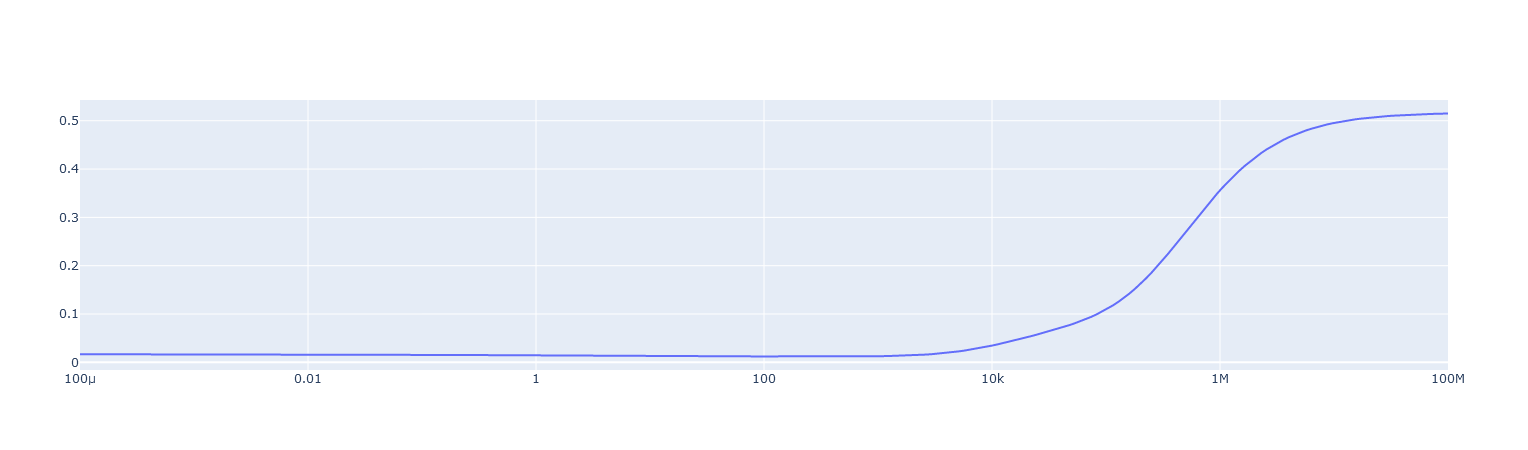

Best smoothing paramter for noise level 001 found is {'smoothness': 320.6447226017888, 'constraint': 320644.7226017888}


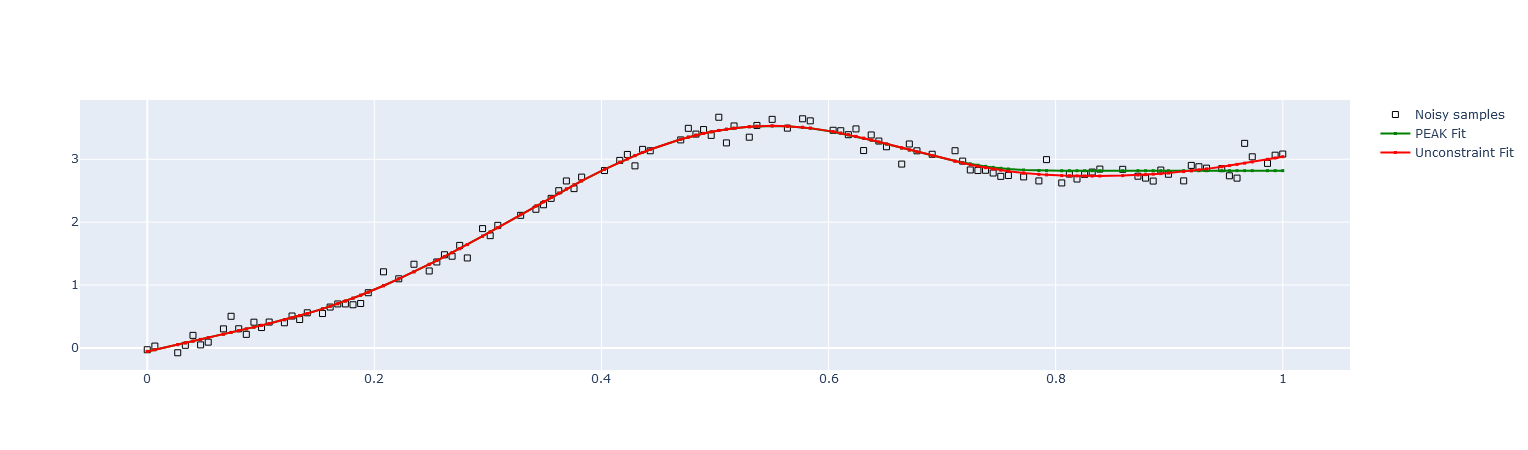

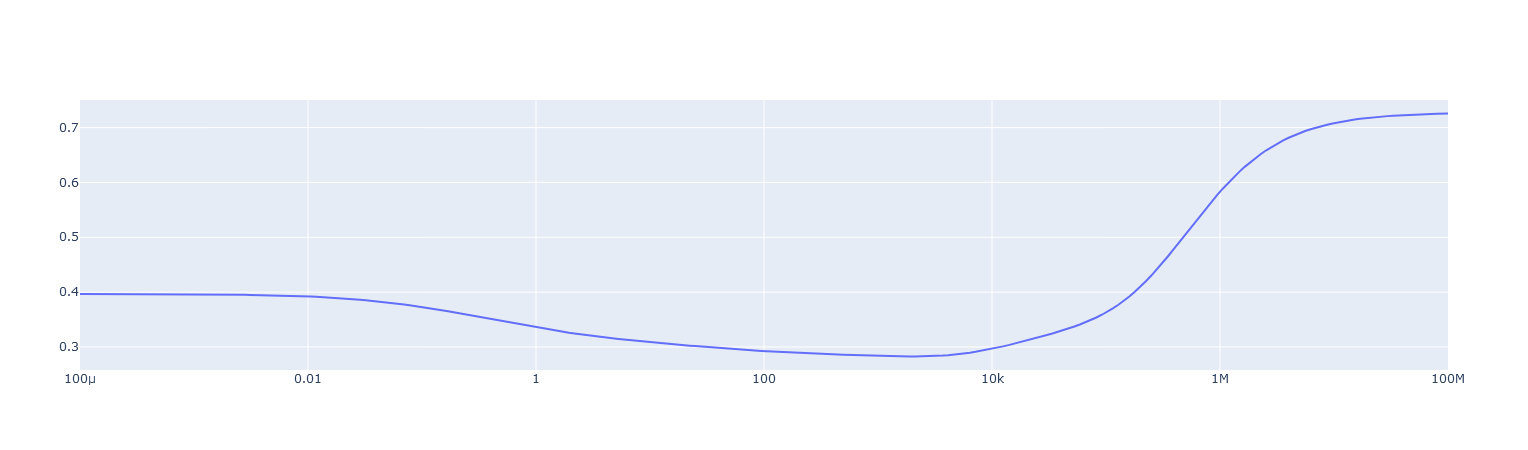

Best smoothing paramter for noise level 005 found is {'smoothness': 1892.8161540172482, 'constraint': 1892816.1540172482}


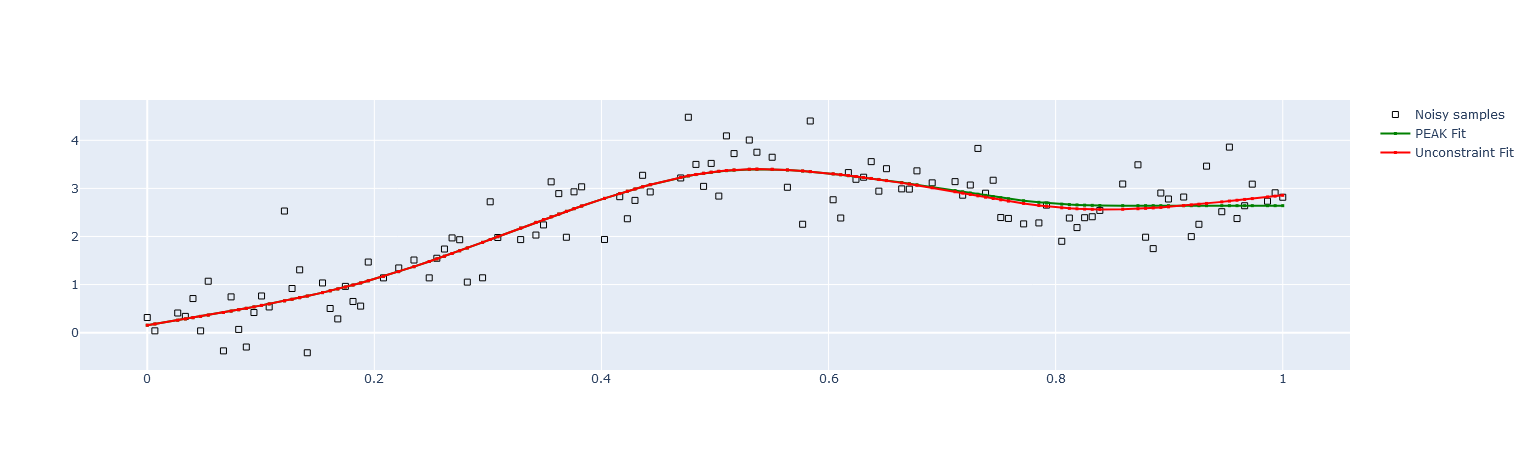

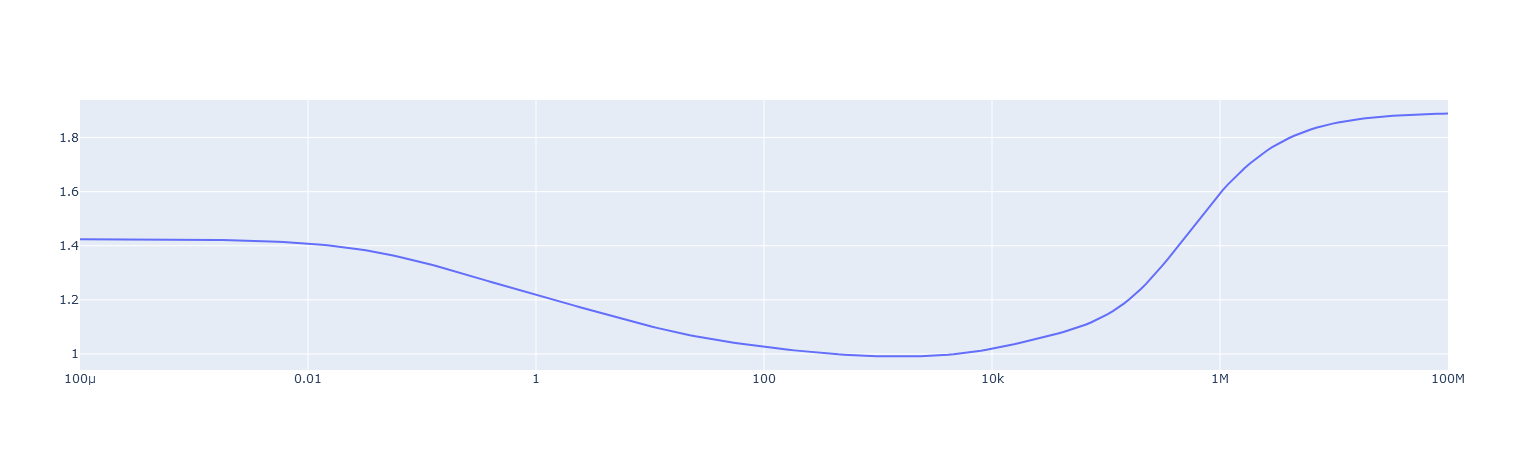

Best smoothing paramter for noise level 010 found is {'smoothness': 1516.0826983319625, 'constraint': 1516082.6983319626}


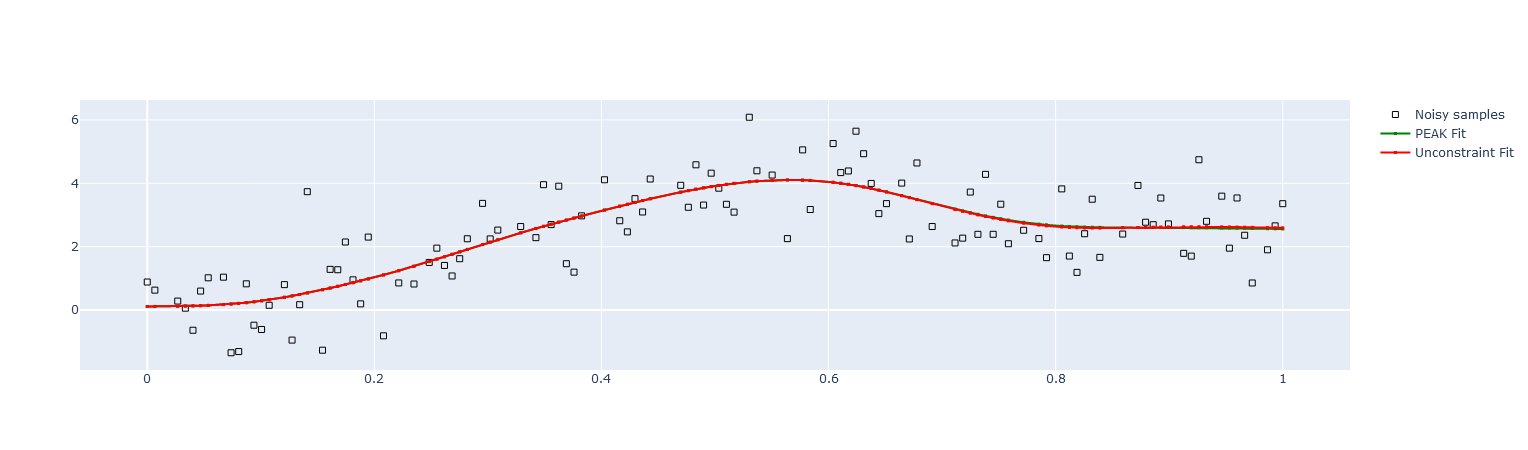

In [15]:
lam_c_list, lam_s_list = [], []
for noise in ["001", "005", "010"]:
# Unconstraint Model
    m_unc = (("s(1)", "none", 35, (1, 0), "equidistant"),)
    M_unc = StarModel(description=m_unc)
    M_unc.GCV_smoothingParameter(X=df_train["x"].values.reshape(-1,1), y=df_train["y_"+noise], n_grid=250, p_max=1e8)
    M_unc.plot_GCV_curve()
    best_lam_s = M_unc.smooths["s(1)"].lam["smoothness"]
    lam_c = 10*best_lam_s
    lam_s_list.append(best_lam_s)
    lam_c_list.append(lam_c)
    print(f"Best smoothing paramter for noise level {noise} found is {M_unc.smooths['s(1)'].lam}")
    yfit_unc = M_unc.basis @ M_unc.coef_

    B = Bspline()
    B.bspline_basis(x_data=df_test["x"].values, k=M_unc.coef_list[-1])
    ypred_unc = B.basis @ M_unc.coef_

    # Constraint Model peak
    m_con = (("s(1)", "peak", 35, (best_lam_s, lam_c), "equidistant"), )
    M_con = StarModel(description=m_con)

    M_con.fit(X=df_train["x"].values.reshape(-1,1), y=df_train["y_"+noise], plot_=False)
    yfit_con = M_con.basis @ M_con.coef_

    B = Bspline()
    B.bspline_basis(x_data=df_test["x"].values, k=M_con.coef_list[-1])
    ypred_con = B.basis @ M_con.coef_

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_train["x"], y=df_train["y_"+noise], mode="markers", marker=dict(size=6, symbol=101, color="black"), name="Noisy samples"))
    fig.add_trace(go.Scatter(x=df_train["x"], y=yfit_con, mode="markers+lines", marker=dict(size=3, symbol=1, color="green"), name="PEAK Fit"))
    fig.add_trace(go.Scatter(x=df_train["x"], y=yfit_unc, mode="markers+lines", marker=dict(size=3, symbol=1, color="red"), name="Unconstraint Fit"))
    fig.show()

    df_train["fit_unc_"+noise] = yfit_unc
    df_train["fit_con_"+noise] = yfit_con
    df_test["pred_unc_"+noise] = ypred_unc
    df_test["pred_con_"+noise] = ypred_con


Plot the constrained and unconstraint fit for Function 1


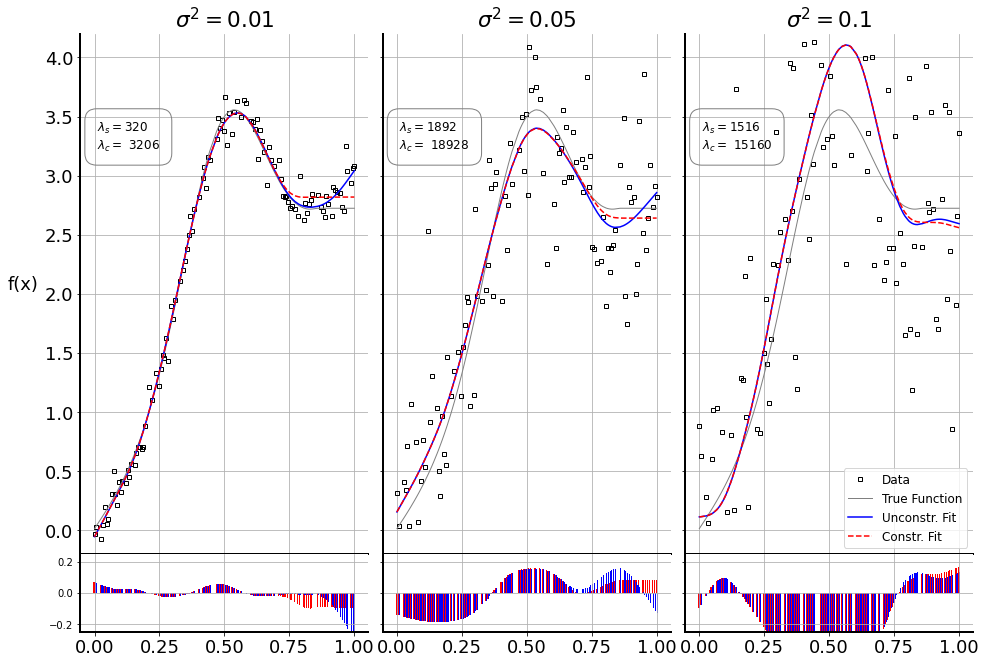

In [37]:
print("Plot the constrained and unconstraint fit for Function 1")
f, axs = plt.subplots(nrows=2, ncols=3, sharex="col", figsize=(16,11),
                      gridspec_kw={"hspace": 0, "height_ratios":[1,0.15], 
                                  "wspace": 0.05})
ax1, ax2 = axs
ax11, ax12, ax13 = ax1
ax21, ax22, ax23 = ax2
# remove the tick labels
for ax in axs.ravel():
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
###############################################################################################
# plot data
###############################################################################################
ip = 1
# customize the left plot
ax11.plot(df_train["x"][::ip], df_train["y_001"][::ip], color="black", label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax11.plot(df_train["x"], df_train["ytrue"], color="grey", linewidth=1, label="True Function")
ax11.plot(df_train["x"], df_train["fit_unc_001"], color="blue", label="Unconstr. Fit")
ax11.plot(df_train["x"], df_train["fit_con_001"], color="red", label="Constr. Fit", linestyle="--")
ax11.set_title(r"$\sigma^2=0.01$")
ax11.set_ylabel("f(x)", labelpad=22, rotation=0)
ax11.set_xlabel("x", labelpad=0)
ax11.set_ylim(bottom=-0.2, top=4.2)
lambda_s = r"$\lambda_s ={}$".format(int(lam_s_list[0]))  
lambda_c = r"$\lambda_c =$ {}".format(int(lam_c_list[0]))
ax11.text(x=0.009, y=3.225, s=lambda_s+"\n"+lambda_c, fontsize=12, color='black', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))
# Customized the middle plot
ax12.plot(df_train["x"][::ip], df_train["y_005"][::ip], color="black", label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax12.plot(df_train["x"], df_train["ytrue"], color="grey", linewidth=1, label="True Function")
ax12.plot(df_train["x"], df_train["fit_unc_005"], color="blue", label="Unconstr. Fit")
ax12.plot(df_train["x"], df_train["fit_con_005"], color="red", label="Constr. Fit", linestyle="--")
ax12.set_title(r"$\sigma^2=0.05$")
ax12.set_xlabel("x", labelpad=0)
ax12.set_ylim(bottom=-0.2, top=4.2)
ax12.set_yticklabels([])
lambda_s = r"$\lambda_s ={}$".format(int(lam_s_list[1]))  
lambda_c = r"$\lambda_c =$ {}".format(int(lam_c_list[1]))
ax12.text(x=0.009, y=3.225, s=lambda_s+"\n"+lambda_c, fontsize=12, color='black', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))
# Customized the left plot
ax13.plot(df_train["x"][::ip], df_train["y_010"][::ip], color="black", label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax13.plot(df_train["x"], df_train["ytrue"], color="grey", linewidth=1, label="True Function")
ax13.plot(df_train["x"], df_train["fit_unc_010"], color="blue", label="Unconstr. Fit")
ax13.plot(df_train["x"], df_train["fit_con_010"], color="red", label="Constr. Fit", linestyle="--")
ax13.set_xlabel("x", labelpad=0)
ax13.set_title(r"$\sigma^2=0.1$")
ax13.legend(fontsize=12, loc="lower right")
ax13.set_ylim(bottom=-0.2, top=4.2)
ax13.set_yticklabels([])
lambda_s = r"$\lambda_s ={}$".format(int(lam_s_list[2]))  
lambda_c = r"$\lambda_c =$ {}".format(int(lam_c_list[2]))
ax13.text(x=0.009, y=3.225, s=lambda_s+"\n"+lambda_c, fontsize=12, color='black', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))
###############################################################################################
# residual plots
###############################################################################################
res_001_unc = df_train["ytrue"] - df_train["fit_unc_001"] 
res_001_con = df_train["ytrue"] - df_train["fit_con_001"]

res_005_unc = df_train["ytrue"] - df_train["fit_unc_005"] 
res_005_con = df_train["ytrue"] - df_train["fit_con_005"]

res_010_unc = df_train["ytrue"] - df_train["fit_unc_010"] 
res_010_con = df_train["ytrue"] - df_train["fit_con_010"]

max_ticks = 1.05*max([max(abs(res_001_con)), max(abs(res_001_unc)), max(abs(res_005_con)), 
                     max(abs(res_005_unc)), max(abs(res_010_con)), max(abs(res_010_unc))])
bar_width = 0.008

ax21.tick_params(axis='y', labelsize=10)
#ax21.set_ylim(bottom=-1.2*max_ticks, top=1.2*max_ticks)
ax21.set_ylim(bottom=-0.25, top=0.25)
ax21.bar(x=df_train["x"]-bar_width/4, color="red", 
         height=res_001_con, width=bar_width/2)
ax21.bar(x=df_train["x"]+bar_width/4, color="blue", 
         height=res_001_unc, width=bar_width/2)

ax22.tick_params(axis='y', labelsize=10)
ax22.set_ylim(bottom=-1.2*max_ticks, top=1.2*max_ticks)
ax22.set_ylim(bottom=-0.25, top=0.25)

ax22.bar(x=df_train["x"]-bar_width/4, color="red", 
         height=res_005_con, width=bar_width/2)
ax22.bar(x=df_train["x"]+bar_width/4, color="blue", 
         height=res_005_unc, width=bar_width/2)
ax22.set_yticklabels([])

ax23.tick_params(axis='y', labelsize=10)
ax23.set_ylim(bottom=-1.2*max_ticks, top=1.2*max_ticks)
ax23.set_ylim(bottom=-0.25, top=0.25)

ax23.bar(x=df_train["x"]-bar_width/4, color="red", 
         height=res_010_con, width=bar_width/2)
ax23.bar(x=df_train["x"]+bar_width/4, color="blue", 
         height=res_010_unc, width=bar_width/2)
ax23.set_yticklabels([])

# plt.savefig('..\\..\\Thesis_WorkingDirectory\\thesisplots\\exp_noise_levels.pdf', transparent=False, bbox_inches='tight')

## **Noise Colors**

In [22]:
np.random.seed(2)
# generate some data
n = 200
x = np.linspace(0,1,n)
ytrue = f1(x)

noise_white = cn.powerlaw_psd_gaussian(exponent=0, size=n, fmin=0.1)*0.1
noise_pink = cn.powerlaw_psd_gaussian(exponent=1, size=n, fmin=0.1)*0.1
noise_brownian = cn.powerlaw_psd_gaussian(exponent=2, size=n, fmin=0.1)*0.1

df = pd.DataFrame(data=dict(x=x, ytrue=ytrue, y_white=ytrue+noise_white, y_pink=ytrue+noise_pink, y_brownian=ytrue+noise_brownian))

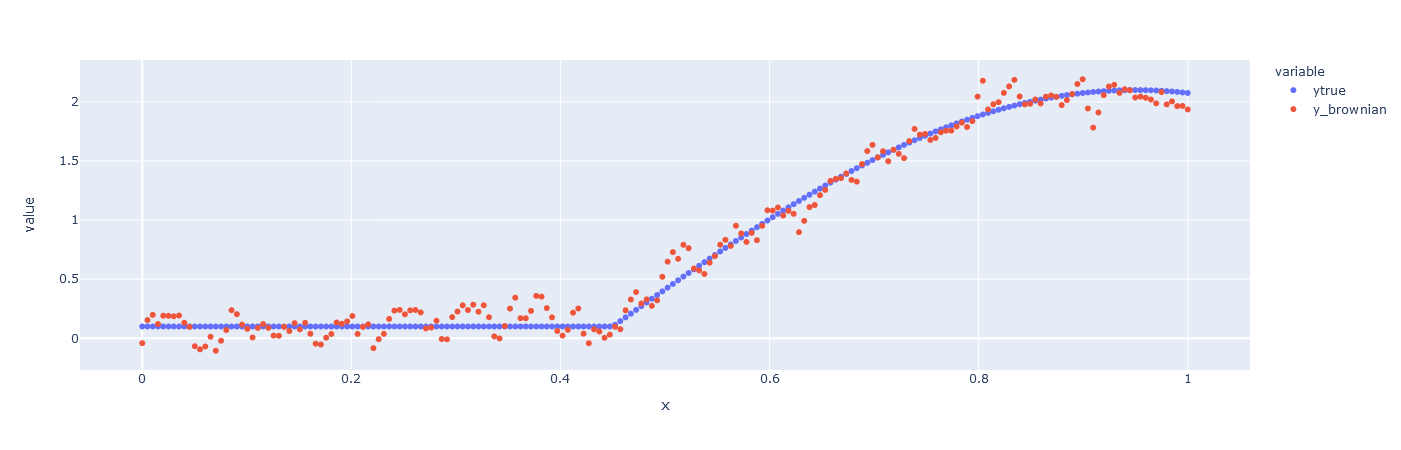

In [21]:
px.scatter(df, x="x", y=["ytrue", "y_brownian"])

In [23]:
# train-test split
cont = True
while cont:
    print("Train-Test-Split")
    df_train, df_test = train_test_split(df, test_size=0.25, shuffle=True)
    df_train = df_train.sort_index()
    df_test = df_test.sort_index()
    if df_train.min()["x"] == 0 and df_train.max()["x"] == 1:
        cont = False
        print("Finished.")

Train-Test-Split
Train-Test-Split
Finished.


### **White, Pink and Brownian Noise**

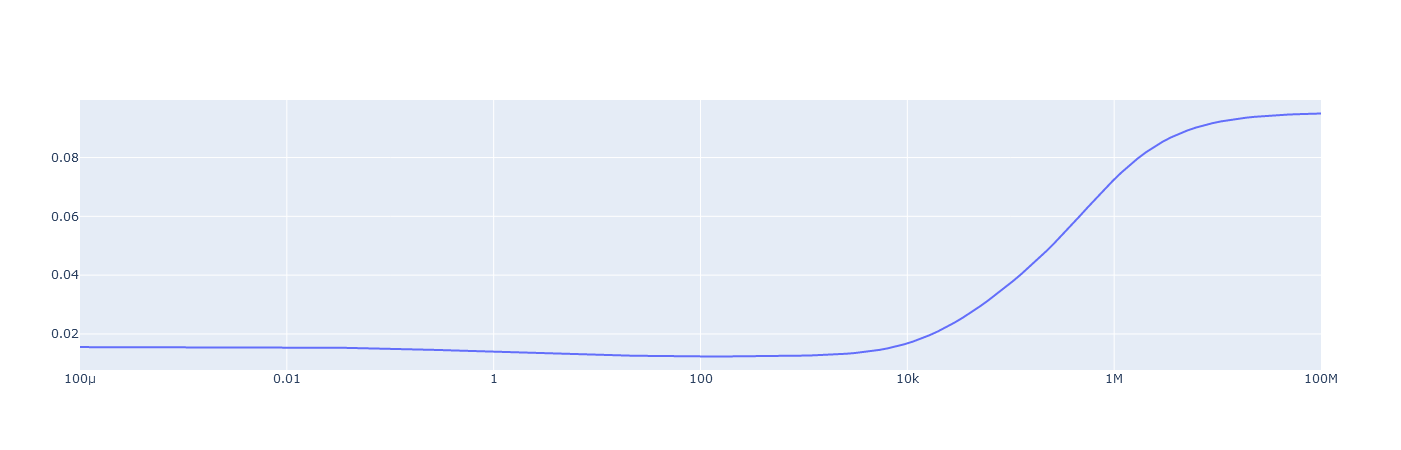

Best smoothing parameter for noise color white found is {'smoothness': 132.0703622736631, 'constraint': 132070.3622736631}
{'s(1)': {'constraint': 'inc',
          'knot_type': 'equidistant',
          'lam': {'constraint': 1320.7036227366311,
                  'smoothness': 132.0703622736631},
          'n_param': 35}}


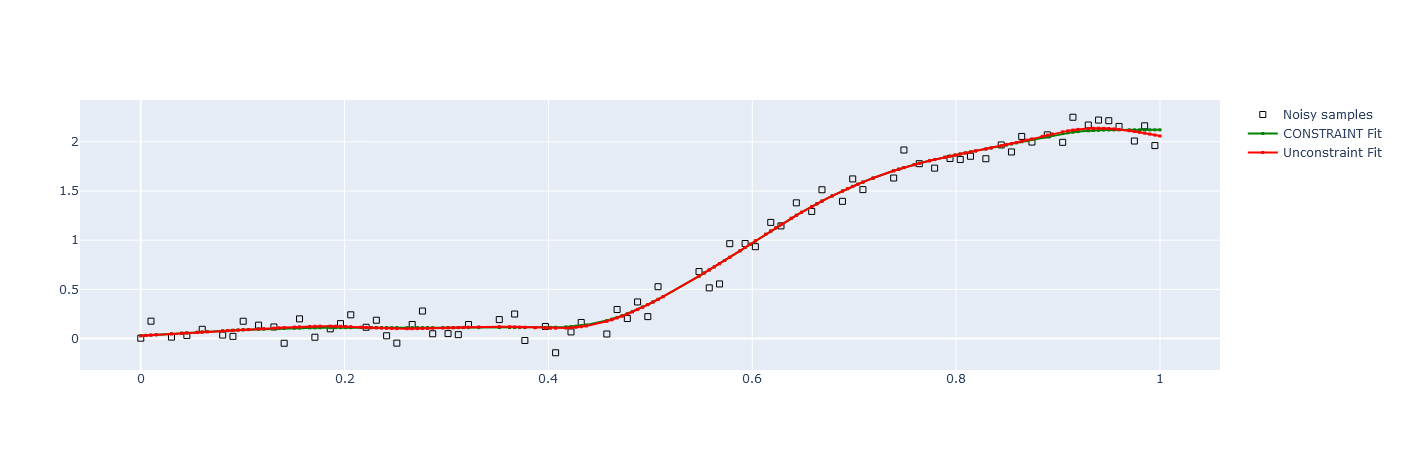

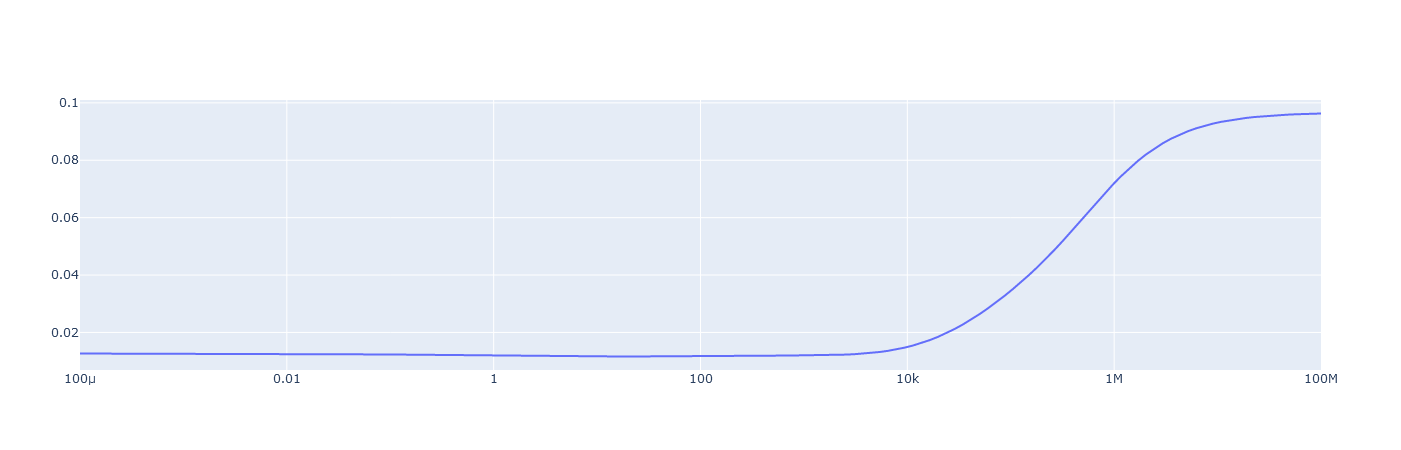

Best smoothing parameter for noise color pink found is {'smoothness': 20.674558382731288, 'constraint': 20674.558382731288}
{'s(1)': {'constraint': 'inc',
          'knot_type': 'equidistant',
          'lam': {'constraint': 2067.455838273129,
                  'smoothness': 20.674558382731288},
          'n_param': 35}}


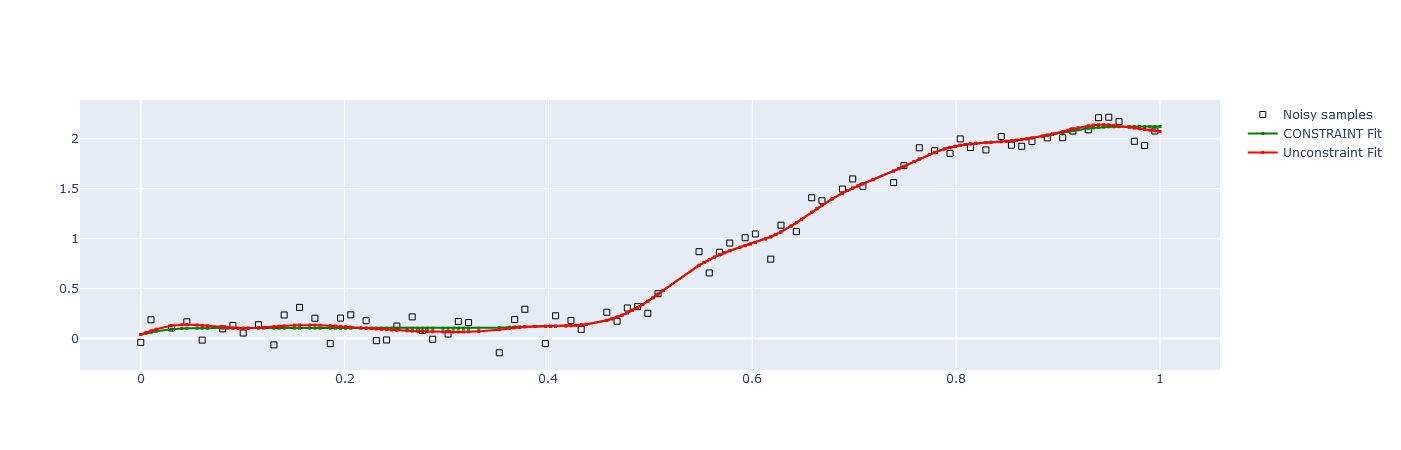

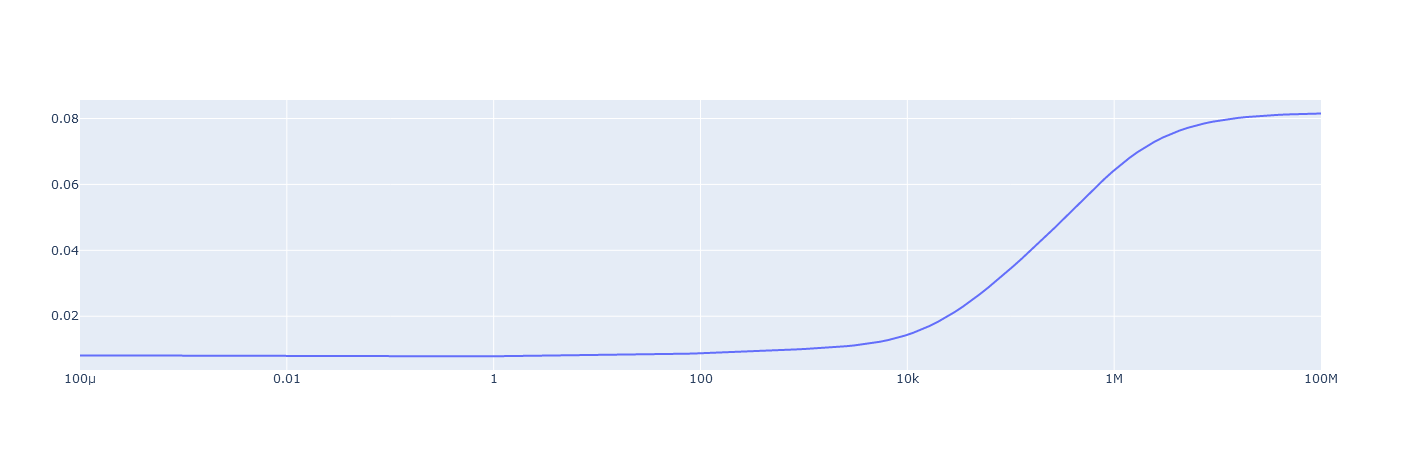

Best smoothing parameter for noise color brownian found is {'smoothness': 0.42088269902088893, 'constraint': 420.88269902088894}
Smoothing Parameter low -> lam_c set to 6000!
{'s(1)': {'constraint': 'inc',
          'knot_type': 'equidistant',
          'lam': {'constraint': 4208.82699020889,
                  'smoothness': 0.42088269902088893},
          'n_param': 35}}


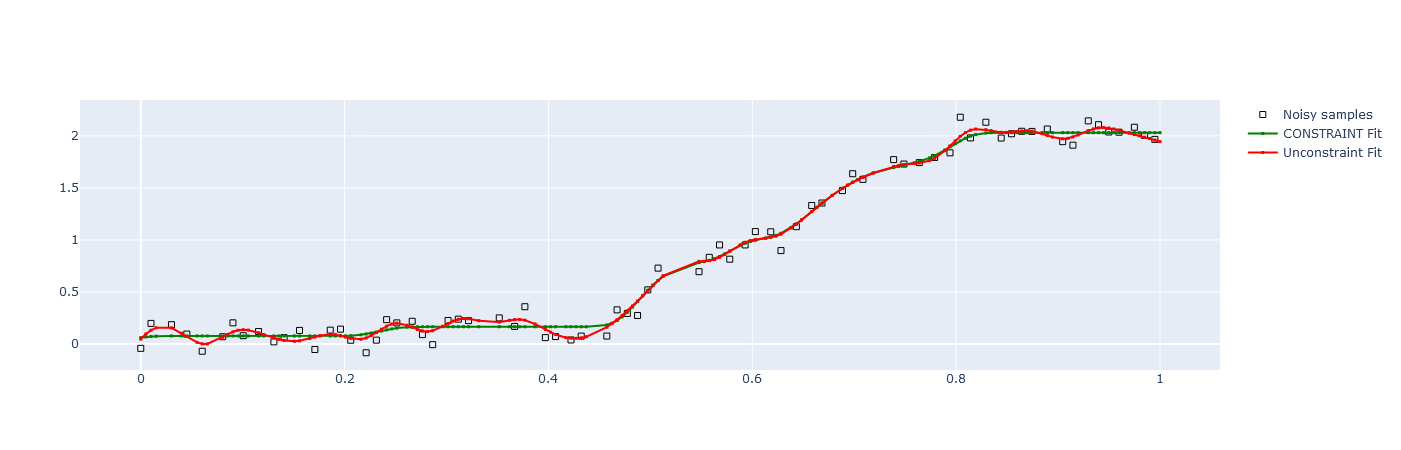

In [42]:
Models_noisecolor = []
lam_c_list, lam_s_list = [],[]
for color in ["white", "pink", "brownian"]:
# Unconstraint Model
    m_unc = (("s(1)", "none", 35, (1, 0), "equidistant"),)
    M_unc = StarModel(description=m_unc)
    M_unc.GCV_smoothingParameter(X=df_train["x"].values.reshape(-1,1), y=df_train["y_"+color], n_grid=150, p_max=1e8)
    M_unc.plot_GCV_curve()
    best_lam_s = M_unc.smooths["s(1)"].lam["smoothness"]
    lam_c = 10*best_lam_s
    print(f"Best smoothing parameter for noise color {color} found is {M_unc.smooths['s(1)'].lam}")
    yfit_unc = M_unc.basis @ M_unc.coef_

    B = Bspline()
    B.bspline_basis(x_data=df_test["x"].values, k=M_unc.coef_list[-1])
    ypred_unc = B.basis @ M_unc.coef_

    # Constraint Model peak
    if best_lam_s < 1:
        lam_c = best_lam_s * 10000
        print("Smoothing Parameter low -> lam_c set to 6000!")
    if 1 < best_lam_s < 100:
        lam_c = best_lam_s * 100
    lam_s_list.append(best_lam_s)
    lam_c_list.append(lam_c)
    m_con = (("s(1)", "inc", 35, (best_lam_s, lam_c), "equidistant"), )
    M_con = StarModel(description=m_con)

    M_con.fit(X=df_train["x"].values.reshape(-1,1), y=df_train["y_"+color], plot_=False)
    print(M_con)
    yfit_con = M_con.basis @ M_con.coef_

    B = Bspline()
    B.bspline_basis(x_data=df_test["x"].values, k=M_con.coef_list[-1])
    ypred_con = B.basis @ M_con.coef_

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df_train["x"][::2], y=df_train["y_"+color][::2], mode="markers", marker=dict(size=6, symbol=101, color="black"), name="Noisy samples"))

    fig.add_trace(go.Scatter(x=df_train["x"], y=yfit_con, mode="markers+lines", marker=dict(size=3, symbol=1, color="green"), name="CONSTRAINT Fit"))
    fig.add_trace(go.Scatter(x=df_train["x"], y=yfit_unc, mode="markers+lines", marker=dict(size=3, symbol=1, color="red"), name="Unconstraint Fit"))
    fig.show()
    df_train["fit_unc_"+color] = yfit_unc
    df_train["fit_con_"+color] = yfit_con
    df_test["pred_unc_"+color] = ypred_unc
    df_test["pred_con_"+color] = ypred_con
    # fig.write_image("example_inc.png")
    Models_noisecolor.append(M_con)

Plot the constrained and unconstraint fit for Function 1


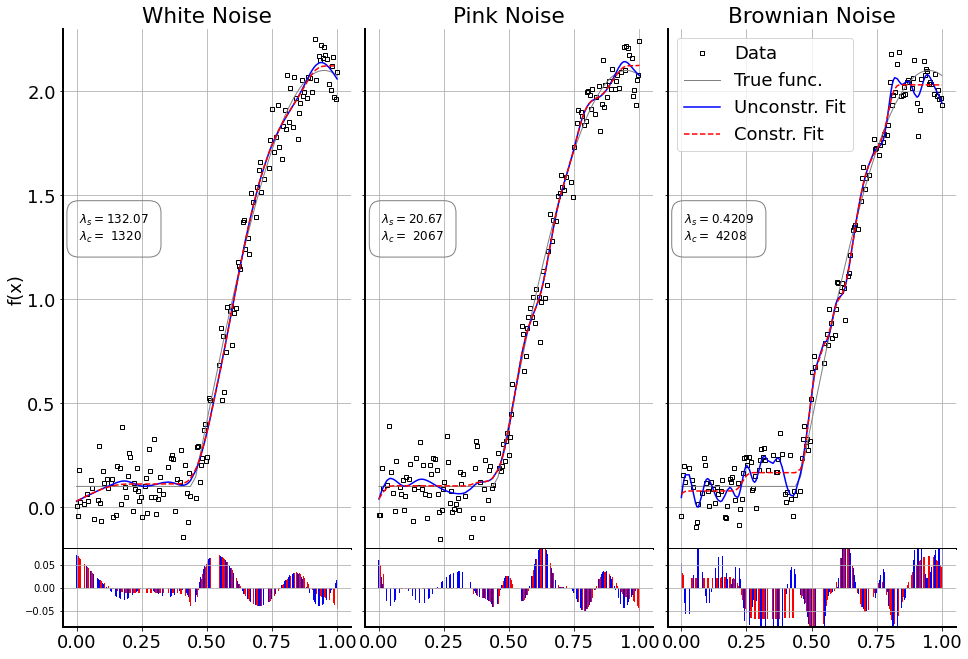

In [44]:
print("Plot the constrained and unconstraint fit for Function 1")
fig, axs = plt.subplots(nrows=2, ncols=3, sharex="col", figsize=(16,11),
                        gridspec_kw={"hspace": 0, "height_ratios":[1,0.15], 
                                     "wspace": 0.05})
ax1, ax2 = axs
ax11, ax12, ax13 = ax1
ax21, ax22, ax23 = ax2
# remove the tick labels
for ax in axs.ravel():
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
###############################################################################################
# plot data
###############################################################################################
ip = 1
# customize the left plot
ax11.plot(df_train["x"][::ip], df_train["y_white"][::ip], color="black", label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax11.plot(df_train["x"], df_train["ytrue"], color="grey", label="True func.", linewidth=1)
ax11.plot(df_train["x"], df_train["fit_unc_white"], color="blue", label="Unconstr. Fit")
ax11.plot(df_train["x"], df_train["fit_con_white"], color="red", label="Constr. Fit", linestyle="--")
ax11.set_title(r"White Noise")
ax11.set_ylabel("f(x)", labelpad=2)
ax11.set_xlabel("x", labelpad=0)
ax11.set_ylim(bottom=-0.2, top=2.3)

lambda_s = r"$\lambda_s ={}$".format(round(lam_s_list[0], 2))  
lambda_c = r"$\lambda_c =$ {}".format(int(lam_c_list[0]))
ax11.text(x=0.009, y=1.28, s=lambda_s+"\n"+lambda_c, fontsize=12, color='black', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))

# Customized the middle plot
ax12.plot(df_train["x"][::ip], df_train["y_pink"][::ip], color="black", label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax12.plot(df_train["x"], df_train["ytrue"], color="grey", label="True func.", linewidth=1)
ax12.plot(df_train["x"], df_train["fit_unc_pink"], color="blue", label="Unconstr. Fit")
ax12.plot(df_train["x"], df_train["fit_con_pink"], color="red", label="Constr. Fit", linestyle="--")
ax12.set_title(r"Pink Noise")
ax12.set_xlabel("x", labelpad=0)
ax12.set_yticklabels([])
ax12.set_ylim(bottom=-0.2, top=2.3)


lambda_s = r"$\lambda_s ={}$".format(round(lam_s_list[1], 2))  
lambda_c = r"$\lambda_c =$ {}".format(int(lam_c_list[1]))
ax12.text(x=0.009, y=1.28, s=lambda_s+"\n"+lambda_c, fontsize=12, color='black', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))

# Customized the left plot
ax13.plot(df_train["x"][::ip], df_train["y_brownian"][::ip], color="black", label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax13.plot(df_train["x"], df_train["ytrue"], color="grey", label="True func.", linewidth=1)
ax13.plot(df_train["x"], df_train["fit_unc_brownian"], color="blue", label="Unconstr. Fit")
ax13.plot(df_train["x"], df_train["fit_con_brownian"], color="red", label="Constr. Fit", linestyle="--")
ax13.set_title(r"Brownian Noise")
ax13.set_xlabel("x", labelpad=0)
ax13.set_ylim(bottom=-0.2, top=2.3)
ax13.set_yticklabels([])

lambda_s = r"$\lambda_s ={}$".format(round(lam_s_list[2], 4))  
lambda_c = r"$\lambda_c =$ {}".format(int(lam_c_list[2]))
ax13.text(x=0.009, y=1.28, s=lambda_s+"\n"+lambda_c, fontsize=12, color='black', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))
###############################################################################################
# residual plots
###############################################################################################
res_unc_white = df_train["ytrue"] - df_train["fit_unc_white"] 
res_con_white = df_train["ytrue"] - df_train["fit_con_white"]

res_unc_pink = df_train["ytrue"] - df_train["fit_unc_pink"] 
res_con_pink = df_train["ytrue"] - df_train["fit_con_pink"]

res_unc_brownian = df_train["ytrue"] - df_train["fit_unc_brownian"] 
res_con_brownian = df_train["ytrue"] - df_train["fit_con_brownian"]

max_ticks = 0.95*max([max(abs(res_unc_brownian)), max(abs(res_unc_pink)), max(abs(res_unc_white)), 
                     max(abs(res_con_brownian)), max(abs(res_con_pink)), max(abs(res_con_white))])
bar_width = np.min(np.diff(df_train["x"]))

max_ticks = 0.07
ax21.tick_params(axis='y', labelsize=10)
ax21.set_ylim(bottom=-1.2*max_ticks, top=1.2*max_ticks)
ax21.bar(x=df_train["x"]+bar_width/4, color="red", height=res_con_white, width=bar_width/2)
ax21.bar(x=df_train["x"]-bar_width/4, color="blue", height=res_unc_white, width=bar_width/2)

ax22.tick_params(axis='y', labelsize=10)
ax22.set_ylim(bottom=-1.2*max_ticks, top=1.2*max_ticks)
ax22.bar(x=df_train["x"]+bar_width/4, color="red", height=res_con_pink, width=bar_width/2)
ax22.bar(x=df_train["x"]-bar_width/4, color="blue", height=res_unc_pink, width=bar_width/2)
ax22.set_yticklabels([])

ax23.tick_params(axis='y', labelsize=10)
ax23.set_ylim(bottom=-1.2*max_ticks, top=1.2*max_ticks)
ax23.bar(x=df_train["x"]-bar_width/4, color="red", height=res_con_brownian, width=bar_width/2)
ax23.bar(x=df_train["x"]+bar_width/4, color="blue", height=res_unc_brownian, width=bar_width/2)
ax23.set_yticklabels([])

ax13.legend()
# fig.savefig('..\\..\\Thesis_WorkingDirectory\\thesisplots\\exp_noise_colors.pdf', transparent=False, bbox_inches='tight')

# **BULK vs. EQUIDISTANT DATA**

In [146]:
def plot_skewed_data_distribution_plots(plots_stats, save_=True, mse_=True):

    color_constr = "red"
    color_unconstr = "blue"
    
    n, experiment, seed = plots_stats
    np.random.seed(seed)

    xlin = np.linspace(0,1,n)
    xtrue = np.linspace(0,1,n)

    if experiment=="l":
        beta_a, beta_b = 1, 3
    elif experiment=="m":
        beta_a, beta_b = 3, 3
    elif experiment=="r":
        beta_a, beta_b = 3, 1

    xbeta = np.random.beta(a=beta_a, b=beta_b, size=n)
    # normalized the beta distribution
    xbeta = (xbeta - xbeta.min()) / (xbeta.max() - xbeta.min()) 
    xbeta.sort()
    noise = np.random.normal(loc=0.0, scale=0.1, size=n)

    ytrue_beta = f2_true(xbeta)
    ytrue_lin = f2_true(xlin)

    ybeta = f2(xbeta)
    ylin = f2(xlin)

    df = pd.DataFrame(data=dict(xlin=xlin, xbeta=xbeta, ytrue_beta=ytrue_beta, ytrue_lin=ytrue_lin, ylin=ylin+noise, ybeta=ybeta+noise))
    #px.scatter(df, x="xlin", y=["ytrue_lin", "ylin"], width=10).show()
    #px.scatter(df, x="xbeta", y=["ytrue_beta", "ybeta"], width=10).show()
    ## train-test split
    cont = True
    while cont:   
        df_train, df_test = train_test_split(df, test_size=0.25, shuffle=True)
        df_train = df_train.sort_index()
        df_test = df_test.sort_index()
        print("Train test split")
        if df_train["xbeta"].values[0] == 0 and df_train["xbeta"].values[-1] == 1:
            cont = False
            print("Finished")

    n_param = 35
    Models_unc_beta = []
    Models_con_beta = []
    for grid in ["equidistant", "quantile"]:
        m_unc_beta = (("s(1)", "none", n_param, (1, 0), grid),)
        M_unc_beta = StarModel(description=m_unc_beta)
        M_unc_beta.GCV_smoothingParameter(X=df_train["xbeta"].values.reshape(-1,1), y=df_train["ybeta"], n_grid=100, p_min=1e-6, p_max=1e8)
        best_lam_s_beta = M_unc_beta.smooths["s(1)"].lam["smoothness"]
        lam_c_beta = 10*best_lam_s_beta
        yfit_unc_beta = M_unc_beta.basis @ M_unc_beta.coef_
        #M_unc_beta.plot_GCV_curve()
        B = Bspline()
        B.bspline_basis(x_data=df_test["xbeta"].values, k=M_unc_beta.coef_list[-1])
        ypred_unc = B.basis @ M_unc_beta.coef_

        if best_lam_s_beta < 1:
            lam_c_beta = best_lam_s_beta * 10000

        # Constraint optimized Model 
        #########################################
        m_con_beta = (("s(1)", "peak", n_param, (best_lam_s_beta, lam_c_beta), grid), )
        M_con_beta = StarModel(description=m_con_beta)
        #########################################
        M_con_beta.fit(X=df_train["xbeta"].values.reshape(-1,1), y=df_train["ybeta"], plot_=False)
        yfit_con_beta = M_con_beta.basis @ M_con_beta.coef_

        B = Bspline()
        B.bspline_basis(x_data=df_test["xbeta"].values, k=M_con_beta.coef_list[-1])
        ypred_con_beta = B.basis @ M_con_beta.coef_

        df_train["fit_unc_beta_"+grid] = yfit_unc_beta
        df_train["fit_con_beta_"+grid] = yfit_con_beta

        Models_unc_beta.append(M_unc_beta)
        Models_con_beta.append(M_con_beta)

        
    cfit_equidistant = np.diag(check_constraint(df_train["fit_con_beta_equidistant"],
                                                constraint="peak",
                                                smooth_type=type(Models_con_beta[0].smooths["s(1)"])))

    cfit_quantile = np.diag(check_constraint(df_train["fit_con_beta_quantile"], 
                                             constraint="peak", 
                                             smooth_type=type(Models_con_beta[1].smooths["s(1)"])))

    ccoef_equidistant = list(
        np.diag(check_constraint(Models_con_beta[0].coef_, 
                                 constraint="peak", 
                                 smooth_type=type(Models_con_beta[0].smooths["s(1)"])))) + [0]
    ccoef_quantile = list(
        np.diag(v=check_constraint(Models_con_beta[1].coef_, 
                                   constraint="peak", 
                                   smooth_type=type(Models_con_beta[1].smooths["s(1)"])))) + [0]
    
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex="col", figsize=(16,11),
                            gridspec_kw={"hspace": 0, "height_ratios":[1,0.15], "wspace": 0.05})
    ax1, ax2 = axs
    ax11, ax12 = ax1
    ax21, ax22 = ax2
    # remove the tick labels
    for ax in axs.ravel():
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

    ##########################################################################
    ##########################################################################
    ## plot the data
    ##########################################################################
    ##########################################################################
    ip = 2 if n==250 else 12
    ##########################################################################
    # left plot for equidistant data
    ax11.plot(df_train["xbeta"][::ip], df_train["ybeta"][::ip], color=col_data, label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
    ax11.plot(df_train["xbeta"], df_train["ytrue_beta"], color="grey", linestyle=":", alpha=0.4, label="True Function")
    ax11.plot(df_train["xbeta"], df_train["fit_unc_beta_equidistant"], color="blue", label="Unconstr. Fit", linestyle="--")
    ax11.plot(df_train["xbeta"], df_train["fit_con_beta_equidistant"], color=color_constr, label="Constr. Fit")

    ax11.set_title("Equidistant Knots")

    equidistant_lambda_s = r"$\lambda_s ={}$".format(round(Models_con_beta[0].smooths["s(1)"].lam["smoothness"], 2))  
    equidistant_lambda_c = r"$\lambda_c =$ {}".format(round(Models_con_beta[0].smooths["s(1)"].lam["constraint"], 1))
    ax11.text(x=0.01, y=3.125, s=equidistant_lambda_s+"\n"+equidistant_lambda_c, fontsize=12, color='black', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))
    ax11.set_ylabel("f(x)", labelpad=20, rotation=0)
    ax11.set_ylim(bottom=-0.2, top=df_train["ybeta"].max()*1.1)
    # plot basis functions
    for i in range(Models_con_beta[0].basis.shape[1]):
        if ccoef_equidistant[i]:
            ax11.plot(df_train["xbeta"], Models_con_beta[0].basis[:,i]*Models_con_beta[0].coef_[i], 
                      color="orange", linewidth=1, linestyle=":")
        else:
            ax11.plot(df_train["xbeta"], Models_con_beta[0].basis[:,i]*Models_con_beta[0].coef_[i], 
                      color="grey", linewidth=1, linestyle=":")
    ##########################################################################
    # right plot for quantile based data
    ax12.plot(df_train["xbeta"][::ip], df_train["ybeta"][::ip], color=col_data, label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
    ax12.plot(df_train["xbeta"], df_train["ytrue_beta"], color="grey", linestyle=":", alpha=0.4, label="True Function")
    ax12.plot(df_train["xbeta"], df_train["fit_unc_beta_quantile"], color="blue", label="Unconstr. Fit", linestyle="--")
    ax12.plot(df_train["xbeta"], df_train["fit_con_beta_quantile"], color=color_constr, label="Constr. Fit")
    
    quantile_lambda_s = r"$\lambda_s ={}$".format(round(Models_con_beta[1].smooths["s(1)"].lam["smoothness"], 4))  
    quantile_lambda_c = r"$\lambda_c =$ {}".format(round(Models_con_beta[1].smooths["s(1)"].lam["constraint"], 1))
    ax12.text(x=0.009, y=3.125, s=quantile_lambda_s+"\n"+quantile_lambda_c, fontsize=12, color='black', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))
    ax12.set_yticklabels([])

    ax12.set_title(r"Quantile based Knots")
    ax12.set_ylim(bottom=-0.2, top=df_train["ybeta"].max()*1.1)
    for i in range(Models_con_beta[1].basis.shape[1]):
        if ccoef_quantile[i]:
            ax12.plot(df_train["xbeta"], Models_con_beta[1].basis[:,i]*Models_con_beta[1].coef_[i], 
                      color="orange", linewidth=1, linestyle=":")
        else:
            ax12.plot(df_train["xbeta"], Models_con_beta[1].basis[:,i]*Models_con_beta[1].coef_[i], 
                      color="grey", linewidth=1, linestyle=":")
    ax12.plot(0, 0, color="grey", linewidth=1, linestyle=":", label="Spline basis")
    ax12.plot(0, 0, color="orange", linewidth=1, linestyle=":", label="Spline basis w. constr. violation")

    ##########################################################################
    ## plot the residuals
    ##########################################################################
    res_unc_equi = df_train["ytrue_beta"] - df_train["fit_unc_beta_equidistant"]
    res_con_equi = df_train["ytrue_beta"] - df_train["fit_con_beta_equidistant"]

    res_unc_quant = df_train["ytrue_beta"] - df_train["fit_unc_beta_quantile"]
    res_con_quant = df_train["ytrue_beta"] - df_train["fit_con_beta_quantile"]

    max_ticks = 0.95*max([max(abs(res_unc_equi)), max(abs(res_unc_quant)),  
                         max(abs(res_con_equi)), max(abs(res_con_quant))])
    bar_width = 0.01
    
    max_ticks = 0.1
    
    ax21.tick_params(axis='y', labelsize=10)
    ax21.set_ylim(bottom=-1.2*max_ticks, top=1.2*max_ticks)
    ax21.bar(x=df_train["xbeta"]+bar_width/4, color=color_constr, height=res_con_equi, width=bar_width/2)
    ax21.bar(x=df_train["xbeta"]-bar_width/4, color="blue", height=res_unc_equi, width=bar_width/2)

    ax22.tick_params(axis='y', labelsize=10)
    ax22.set_ylim(bottom=-1.2*max_ticks, top=1.2*max_ticks)
    ax22.bar(x=df_train["xbeta"]+bar_width/4, color=color_constr, height=res_con_quant, width=bar_width/2)
    ax22.bar(x=df_train["xbeta"]-bar_width/4, color="blue", height=res_unc_quant, width=bar_width/2)
    ax22.set_yticklabels([])
    
    #plt.suptitle(r"Beta({},{})-distribution data".format(beta_a, beta_b))

    path = "..\\..\\Thesis_WorkingDirectory\\thesisplots\\"
    if experiment=="l":
        fname = "exp_left_skewed_data_ndata_{}_rseed_{}".format(n, seed)
        print("Left Skewed Data Distribution")
    elif experiment=="m":
        fname = "exp_middle_skewed_data_ndata_{}_rseed_{}".format(n, seed)
        print("Middle Skewed Data Distribution")
    elif experiment=="r":
        fname = "exp_right_skewed_data_ndata_{}_rseed_{}".format(n, seed)
        print("Right Skewed Data Distribution")

        
    ax12.legend(bbox_to_anchor=(0.4, 0.4), loc="upper left", frameon=True, fontsize=16, )
    # ax12.legend(bbox_to_anchor=(0.9, 1.), loc="upper left", frameon=True, fontsize=16, )
    
    if save_:
        print("Save plot to : ", path+"exp_beta\\"+fname+".pdf")
        fig.savefig(path+"exp_beta\\"+fname+".pdf", transparent=False, bbox_inches='tight')
        
    if mse_:
        print("MSEs and AIC for knot placement types and left skew data!".center(100, "="))
        print("".center(50, "-"))
        print("MSE equidistant unconstraint on noisy samples: ".ljust(52), mean_squared_error(df_train["ytrue_beta"], df_train["fit_unc_beta_equidistant"]).round(8))
        print("MSE quantile unconstraint on noisy samples: ".ljust(52), mean_squared_error(df_train["ytrue_beta"], df_train["fit_unc_beta_quantile"]).round(8))
        print("MSE equidistant constr. : ".ljust(52), mean_squared_error(df_train["ytrue_beta"], df_train["fit_con_beta_equidistant"]).round(8))
        print("MSE quantile constr.: ".ljust(52), mean_squared_error(df_train["ytrue_beta"], df_train["fit_con_beta_quantile"]).round(8))

        print("".center(50, "-"))
        print("MSE equidistant unconstraint on test set: ".ljust(42), mean_squared_error(df_test["ytrue_beta"], Models_unc_beta[0].predict(X=df_test["xbeta"].values.reshape((-1,1)))).round(8))
        print("MSE quantile unconstraint on test set: ".ljust(42), mean_squared_error(df_test["ytrue_beta"], Models_unc_beta[1].predict(X=df_test["xbeta"].values.reshape((-1,1)))).round(8))
        print("MSE equidistant constr. : ".ljust(42), mean_squared_error(df_test["ytrue_beta"],  Models_con_beta[0].predict(X=df_test["xbeta"].values.reshape((-1,1)))).round(8))
        print("MSE quantile constr. : ".ljust(42), mean_squared_error(df_test["ytrue_beta"],  Models_con_beta[1].predict(X=df_test["xbeta"].values.reshape((-1,1)))).round(8))

        print("".center(50, "-"))
        print("AIC equidistant unconstraint: ".ljust(35), AIC(model=Models_unc_beta[0], ytest=df_test["ytrue_beta"], Xtest=df_test["xbeta"].values.reshape((-1,1))))
        print("AIC quantile unconstraint: ".ljust(35), AIC(model=Models_unc_beta[1], ytest=df_test["ytrue_beta"], Xtest=df_test["xbeta"].values.reshape((-1,1))))
        print("AIC equidistant constr: ".ljust(35), AIC(model=Models_con_beta[0], ytest=df_test["ytrue_beta"], Xtest=df_test["xbeta"].values.reshape((-1,1))))
        print("AIC quantile constr: ".ljust(35), AIC(model=Models_con_beta[1], ytest=df_test["ytrue_beta"], Xtest=df_test["xbeta"].values.reshape((-1,1))))
        
    return Models_con_beta, Models_unc_beta, df_train, df_test

skewed_data_plot_stats = [
    (250, "l", 1), (250, "l", 2), 
    (250, "r", 1), (250, "r", 2), 
    (250, "m", 1), (250, "m", 2), 
    (2500, "l", 1),(2500, "l", 2)]


Train test split
Finished
Left Skewed Data Distribution
Save plot to :  ..\..\Thesis_WorkingDirectory\thesisplots\exp_beta\exp_left_skewed_data_ndata_2500_rseed_1.pdf
=====================MSEs and AIC for knot placement types and left skew data!======================
--------------------------------------------------
MSE equidistant unconstraint on noisy samples:       0.00022539
MSE quantile unconstraint on noisy samples:          0.0003758
MSE equidistant constr. :                            0.00012946
MSE quantile constr.:                                0.00032971
--------------------------------------------------
MSE equidistant unconstraint on test set:  0.00011979
MSE quantile unconstraint on test set:     0.000227
MSE equidistant constr. :                  0.00013087
MSE quantile constr. :                     0.00033315
--------------------------------------------------
AIC equidistant unconstraint:       -5605.408486275452
AIC quantile unconstraint:          -5136.100497286702


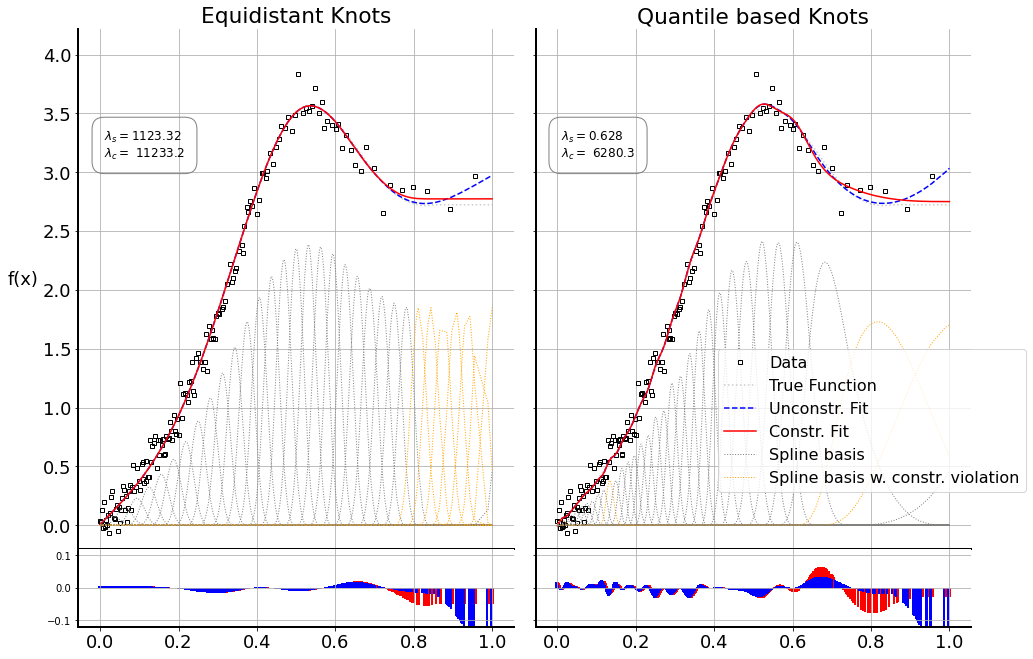

In [147]:
Model_con_beta, Model_unc_beta, df_train, df_test = plot_skewed_data_distribution_plots(skewed_data_plot_stats[6], save_=True)


In [117]:
df_test.head()

xlin     xbeta  ytrue_beta  ytrue_lin      ylin     ybeta
13  0.052209  0.022500    0.088421   0.192881  0.299356  0.194896
15  0.060241  0.022903    0.089791   0.222533  0.306792  0.174049
16  0.064257  0.026872    0.103351   0.237627  0.129609 -0.004668
17  0.068273  0.026989    0.103751   0.252912  0.212717  0.063555
18  0.072289  0.027197    0.104467   0.268398  0.122926 -0.041004

In [124]:
print("MSEs and AIC for knot placement types and left skew data!".center(100, "="))
print("".center(50, "-"))
print("MSE equidistant unconstraint on noisy samples: ".ljust(52), mean_squared_error(df_train["ytrue_beta"], df_train["fit_unc_beta_equidistant"]).round(8))
print("MSE quantile unconstraint on noisy samples: ".ljust(52), mean_squared_error(df_train["ytrue_beta"], df_train["fit_unc_beta_quantile"]).round(8))
print("MSE equidistant constr. : ".ljust(52), mean_squared_error(df_train["ytrue_beta"], df_train["fit_con_beta_equidistant"]).round(8))
print("MSE quantile constr.: ".ljust(52), mean_squared_error(df_train["ytrue_beta"], df_train["fit_con_beta_quantile"]).round(8))

print("".center(50, "-"))
print("MSE equidistant unconstraint on test set: ".ljust(42), mean_squared_error(df_test["ytrue_beta"], Model_unc_beta[0].predict(X=df_test["xbeta"].values.reshape((-1,1)))).round(8))
print("MSE quantile unconstraint on test set: ".ljust(42), mean_squared_error(df_test["ytrue_beta"], Model_unc_beta[1].predict(X=df_test["xbeta"].values.reshape((-1,1)))).round(8))
print("MSE equidistant constr. : ".ljust(42), mean_squared_error(df_test["ytrue_beta"],  Model_con_beta[0].predict(X=df_test["xbeta"].values.reshape((-1,1)))).round(8))
print("MSE quantile constr. : ".ljust(42), mean_squared_error(df_test["ytrue_beta"],  Model_con_beta[1].predict(X=df_test["xbeta"].values.reshape((-1,1)))).round(8))

print("".center(50, "-"))
print("AIC equidistant unconstraint: ".ljust(35), AIC(model=Model_unc_beta[0], ytest=df_test["ytrue_beta"], Xtest=df_test["xbeta"].values.reshape((-1,1))))
print("AIC quantile unconstraint: ".ljust(35), AIC(model=Model_unc_beta[1], ytest=df_test["ytrue_beta"], Xtest=df_test["xbeta"].values.reshape((-1,1))))
print("AIC equidistant constr: ".ljust(35), AIC(model=Model_con_beta[0], ytest=df_test["ytrue_beta"], Xtest=df_test["xbeta"].values.reshape((-1,1))))
print("AIC quantile constr: ".ljust(35), AIC(model=Model_con_beta[1], ytest=df_test["ytrue_beta"], Xtest=df_test["xbeta"].values.reshape((-1,1))))

=====================MSEs and AIC for knot placement types and left skew data!======================
--------------------------------------------------
MSE equidistant unconstraint on noisy samples:       0.00098697
MSE quantile unconstraint on noisy samples:          0.00245659
MSE equidistant constr. :                            0.0007763
MSE quantile constr.:                                0.00140713
--------------------------------------------------
MSE equidistant unconstraint on test set:  0.00074039
MSE quantile unconstraint on test set:     0.00207701
MSE equidistant constr. :                  0.00109132
MSE quantile constr. :                     0.00177764
--------------------------------------------------
AIC equidistant unconstraint:       -421.3408205846313
AIC quantile unconstraint:          -266.17512613165644
AIC equidistant constr:             -400.18548145379617
AIC quantile constr:                -311.49911501351335


Left Skewed Data Distribution
Save plot to :  ..\..\Thesis_WorkingDirectory\thesisplots\exp_beta\exp_left_skewed_data_ndata_250_rseed_1.pdf
Left Skewed Data Distribution
Save plot to :  ..\..\Thesis_WorkingDirectory\thesisplots\exp_beta\exp_left_skewed_data_ndata_250_rseed_2.pdf
Right Skewed Data Distribution
Save plot to :  ..\..\Thesis_WorkingDirectory\thesisplots\exp_beta\exp_right_skewed_data_ndata_250_rseed_1.pdf
Right Skewed Data Distribution
Save plot to :  ..\..\Thesis_WorkingDirectory\thesisplots\exp_beta\exp_right_skewed_data_ndata_250_rseed_2.pdf
Middle Skewed Data Distribution
Save plot to :  ..\..\Thesis_WorkingDirectory\thesisplots\exp_beta\exp_middle_skewed_data_ndata_250_rseed_1.pdf
Middle Skewed Data Distribution
Save plot to :  ..\..\Thesis_WorkingDirectory\thesisplots\exp_beta\exp_middle_skewed_data_ndata_250_rseed_2.pdf
Left Skewed Data Distribution
Save plot to :  ..\..\Thesis_WorkingDirectory\thesisplots\exp_beta\exp_left_skewed_data_ndata_2500_rseed_1.pdf
Left Sk

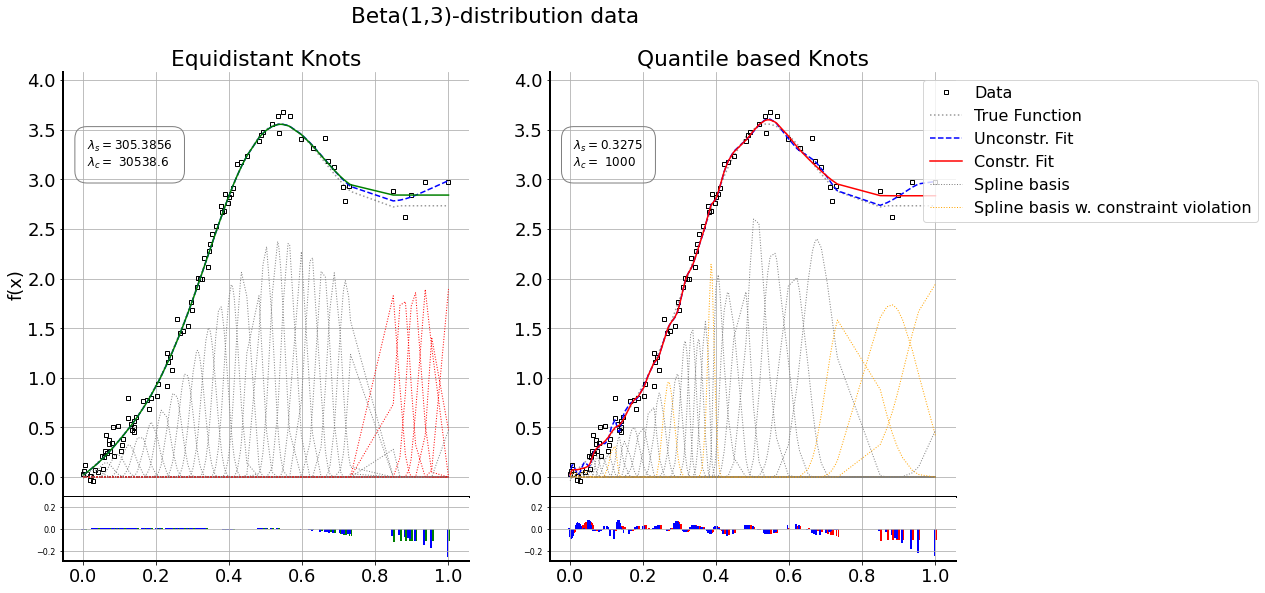

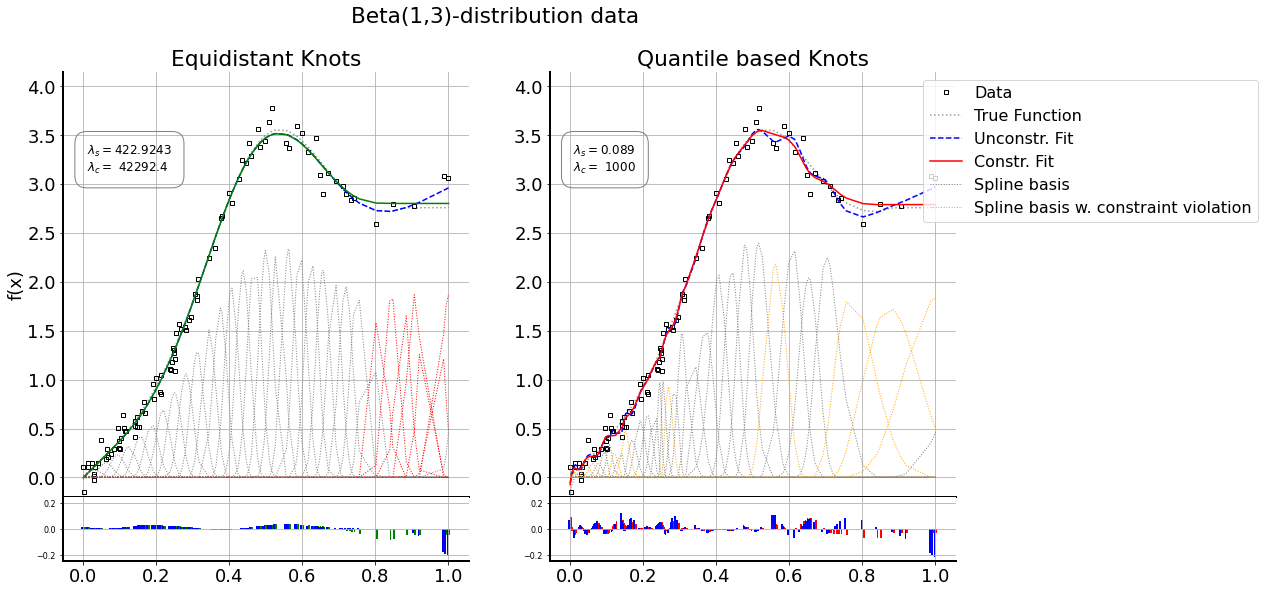

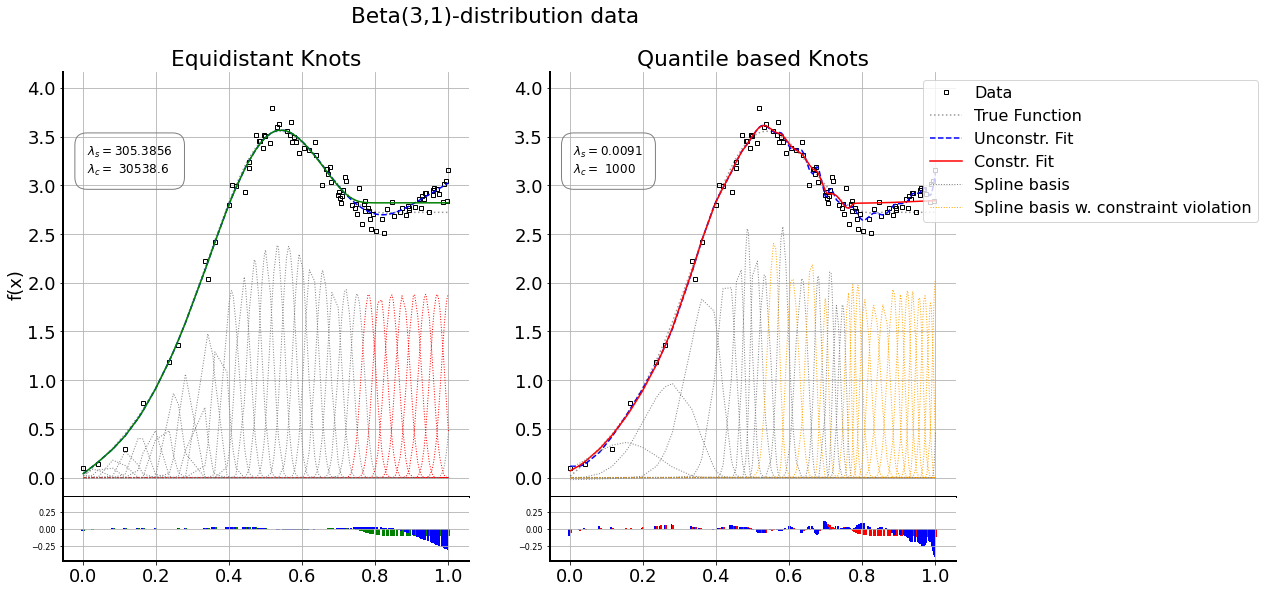

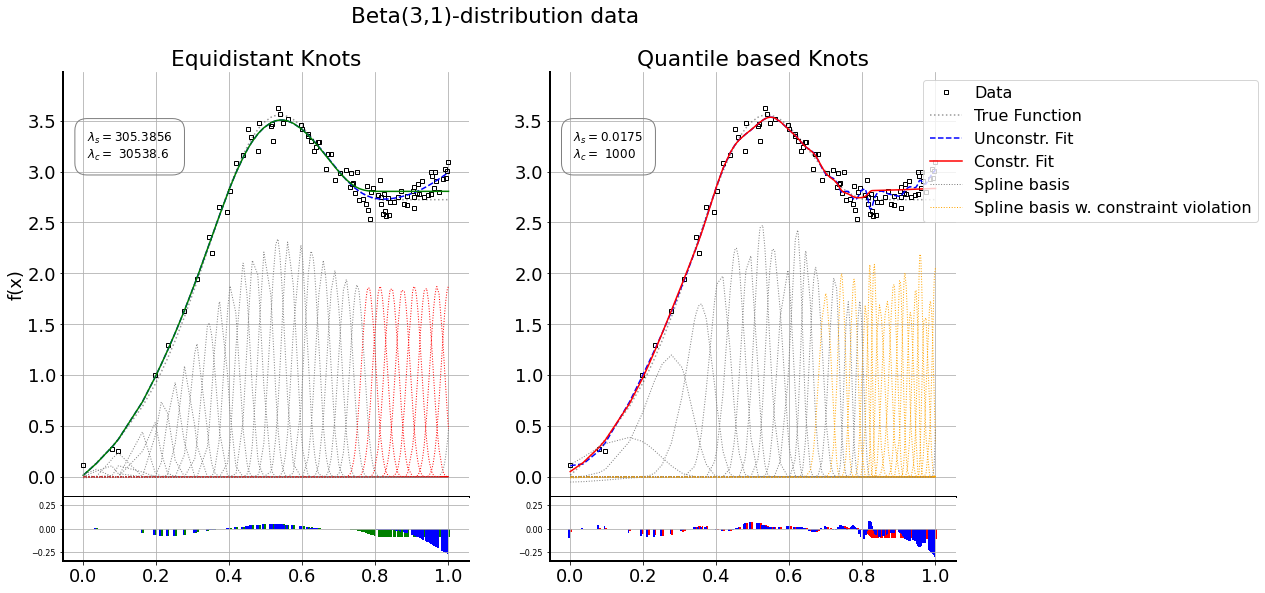

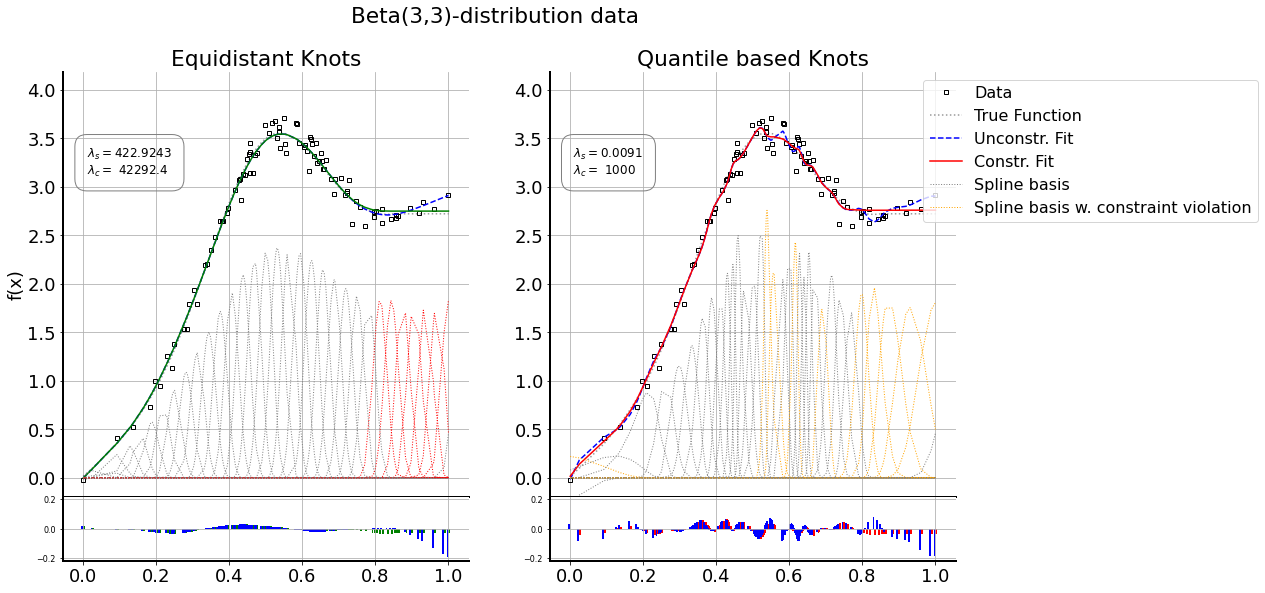

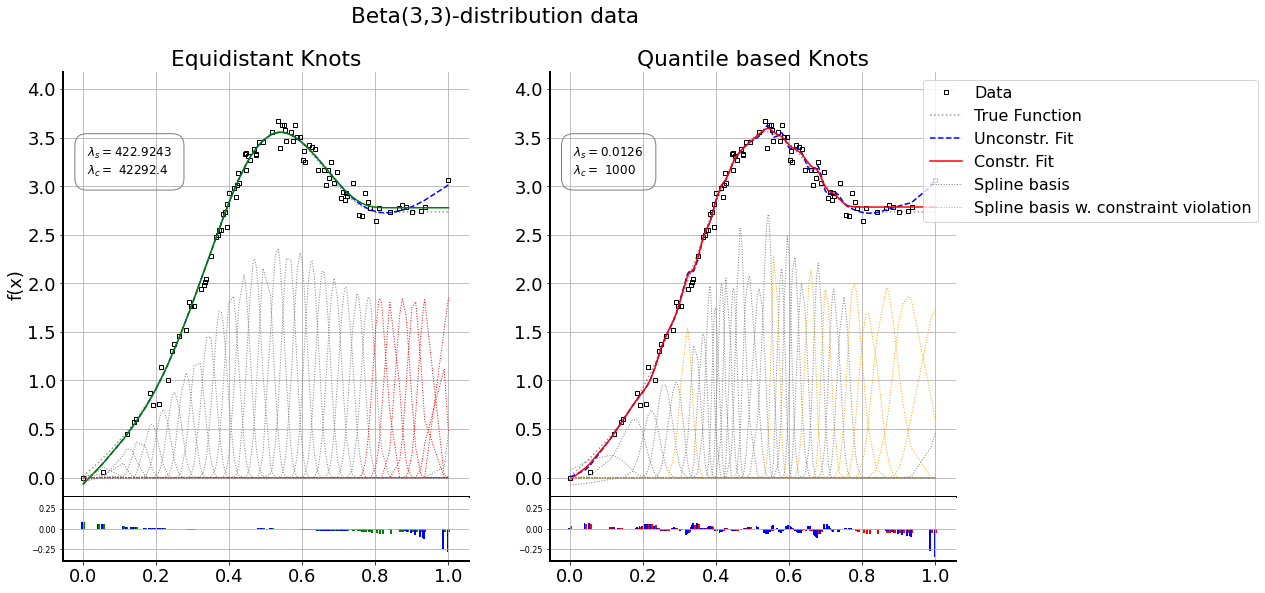

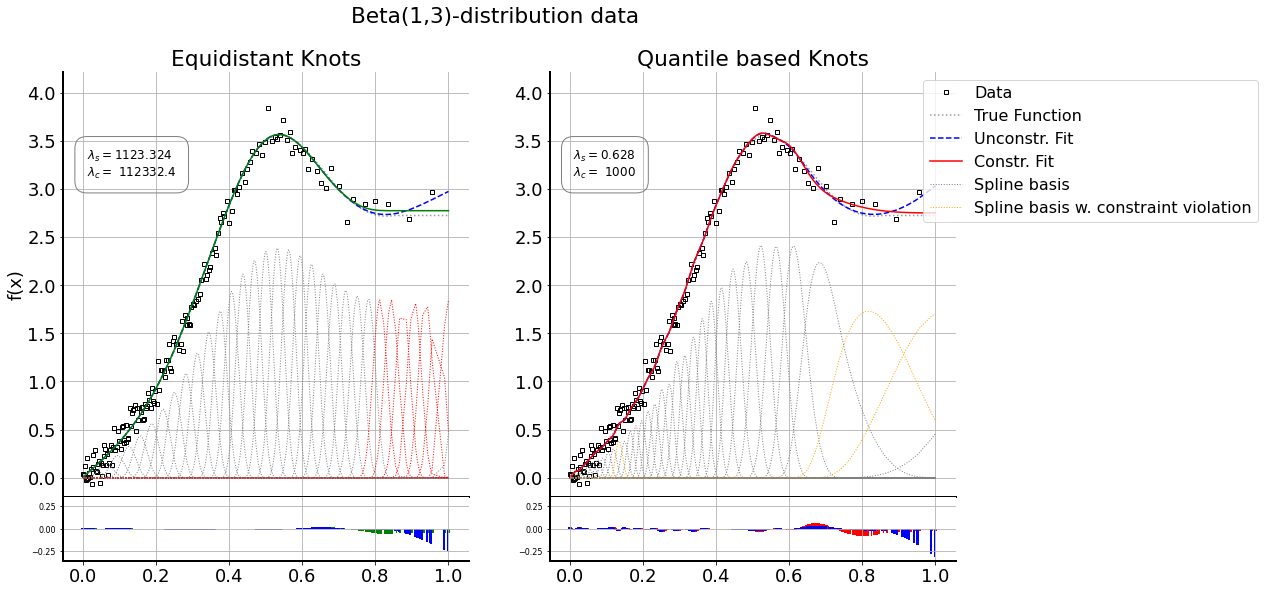

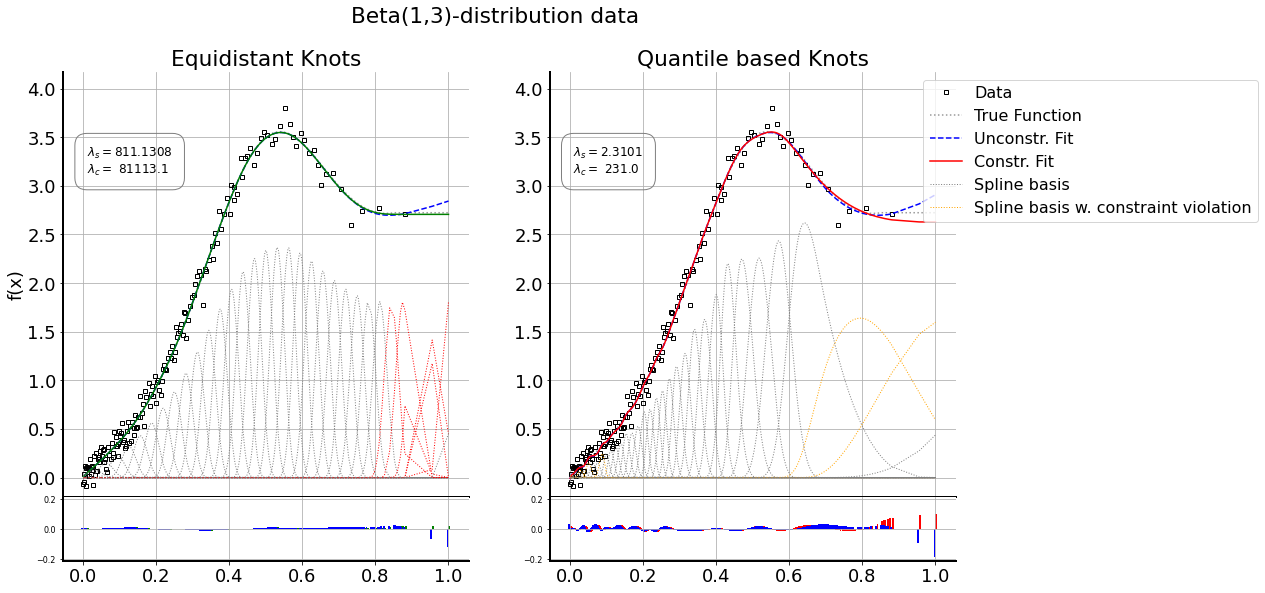

In [5]:
for stat in skewed_data_plot_stats:
    plot_skewed_data_distribution_plots(stat, save_=True)
print("Finished.")

### **Equidistant vs Quantile Based for LINEAR SPACED DATA**

In [76]:
n, seed = 250, 1

color_constr = "red"
color_unconstr = "blue"

np.random.seed(seed)

xlin = np.linspace(0,1,n)
noise = np.random.normal(loc=0.0, scale=0.05, size=n)

ytrue_lin = f2_true(xlin)
ylin = f2(xlin)
df = pd.DataFrame(data=dict(xlin=xlin, ytrue_lin=ytrue_lin, ylin=ylin+noise))

cont = True
while cont:   
    df_train, df_test = train_test_split(df, test_size=0.25, shuffle=True)
    df_train = df_train.sort_index()
    df_test = df_test.sort_index()
    print("Train test split")
    if df_train["xlin"].values[0] == 0 and df_train["xlin"].values[-1] == 1:
        cont = False
        print("Finished")

Train test split
Finished


In [78]:
n_param = 35
Models_lin = []
Models_lin_unc = []
print("Linear space data")
for grid in ["equidistant", "quantile"]:
    m_unc_linsp = (("s(1)", "none", n_param, (1, 0), grid),)
    M_unc_linsp = StarModel(description=m_unc_linsp)
    M_unc_linsp.GCV_smoothingParameter(X=df_train["xlin"].values.reshape(-1,1), y=df_train["ylin"], n_grid=25)
    Models_lin_unc.append(M_unc_linsp)
    best_lam_s_linsp = M_unc_linsp.smooths["s(1)"].lam["smoothness"]
    lam_c_linsp = 10*best_lam_s_linsp
    print(f"Best smoothing parameter for {grid} is {M_unc_linsp.smooths['s(1)'].lam}")
    
    M_unc_linsp = StarModel(description=(("s(1)", "none", n_param, (best_lam_s_linsp, 0), grid),))
    M_unc_linsp.fit(X=df_train["xlin"].values.reshape(-1,1), y=df_train["ylin"],plot_=False)
    yfit_unc_linsp = M_unc_linsp.basis @ M_unc_linsp.coef_

    B = Bspline()
    B.bspline_basis(x_data=df_test["xlin"].values, k=M_unc_linsp.coef_list[-1])
    ypred_unc = B.basis @ M_unc_linsp.coef_

    if  lam_c_linsp < 1000:
        if n == 250:
            lam_c_linsp = 4000
        print("Constraint Parameter low -> set to 1000!")

    # Constraint Model peak
    m_con_linsp = (("s(1)", "peak", 35, (best_lam_s_linsp, lam_c_linsp), grid), )
    M_con_linsp = StarModel(description=m_con_linsp)

    M_con_linsp.fit(X=df_train["xlin"].values.reshape(-1,1), y=df_train["ylin"], plot_=False)
    yfit_con_linsp = M_con_linsp.basis @ M_con_linsp.coef_

    B = Bspline()
    B.bspline_basis(x_data=df_test["xlin"].values, k=M_con_linsp.coef_list[-1])
    ypred_con_linsp = B.basis @ M_con_linsp.coef_
    
    df_train["fit_unc_linspace_"+grid] = yfit_unc_linsp
    df_train["fit_con_linspace_"+grid] = yfit_con_linsp
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_train["xlin"], y=df_train["ylin"], mode="markers", marker=dict(size=6, symbol=101, color="black"), name="Noisy samples"))
    fig.add_trace(go.Scatter(x=df_train["xlin"], y=yfit_con_linsp, mode="markers+lines", marker=dict(size=3, symbol=1, color="green"), name="CONSTRAINT Fit"))
    fig.add_trace(go.Scatter(x=df_train["xlin"], y=yfit_unc_linsp, mode="markers+lines", marker=dict(size=3, symbol=1, color=color_constr), name="Unconstraint Fit"))
    for i in range(M_con_linsp.basis.shape[1]):
        fig.add_trace(go.Scatter(x=df_train["xlin"], y=M_con_linsp.basis[:,i] * M_con_linsp.coef_[i], mode="lines", line=dict(color="grey", width=1), name=None))
    #fig.show()
    
    Models_lin.append(M_con_linsp)

    
print("Equidistant knot Model: ".center(50, "-"), "\n", Models_lin[0])
print("Quantile knot Model: ".center(50, "-"), "\n", Models_lin[1])

cfit_equidistant = np.diag(check_constraint(df_train["fit_con_linspace_equidistant"],
                                            constraint="peak",
                                            smooth_type=type(Models_lin[0].smooths["s(1)"])))

cfit_quantile = np.diag(check_constraint(df_train["fit_con_linspace_quantile"], 
                                         constraint="peak", 
                                         smooth_type=type(Models_lin[1].smooths["s(1)"])))

ccoef_equidistant = list(
    np.diag(check_constraint(Models_lin[0].coef_, 
                             constraint="peak", 
                             smooth_type=type(Models_lin[0].smooths["s(1)"])))) + [0]
ccoef_quantile = list(
    np.diag(v=check_constraint(Models_lin[1].coef_, 
                               constraint="peak", 
                               smooth_type=type(Models_lin[1].smooths["s(1)"])))) + [0]

Linear space data
Best smoothing parameter for equidistant is {'smoothness': 17.78279410038923, 'constraint': 17782.79410038923}
Constraint Parameter low -> set to 1000!
Best smoothing parameter for quantile is {'smoothness': 0.005623413251903491, 'constraint': 5.623413251903491}
Constraint Parameter low -> set to 1000!
-------------Equidistant knot Model: ------------- 
 {'s(1)': {'constraint': 'peak',
          'knot_type': 'equidistant',
          'lam': {'constraint': 4000, 'smoothness': 17.78279410038923},
          'n_param': 35}}
--------------Quantile knot Model: --------------- 
 {'s(1)': {'constraint': 'peak',
          'knot_type': 'quantile',
          'lam': {'constraint': 4000, 'smoothness': 0.005623413251903491},
          'n_param': 35}}


In [87]:
df_test.head()

xlin  ytrue_lin      ylin
2   0.008032   0.039900  0.013492
6   0.024096   0.093857  0.181098
8   0.032129   0.121485  0.137436
10  0.040161   0.149615  0.222720
19  0.076305   0.284093  0.313234

In [93]:
print("MSEs and AIC for knot placement types and grid data!".center(100, "="))
print("".center(50, "-"))
print("MSE equidistant unconstraint on noisy samples: ".ljust(52), mean_squared_error(df_train["ytrue_lin"], df_train["fit_unc_linspace_equidistant"]).round(8))
print("MSE quantile unconstraint on noisy samples: ".ljust(52), mean_squared_error(df_train["ytrue_lin"], df_train["fit_unc_linspace_quantile"]).round(8))
print("MSE equidistant constr. : ".ljust(52), mean_squared_error(df_train["ytrue_lin"], df_train["fit_con_linspace_equidistant"]).round(8))
print("MSE quantile constr.: ".ljust(52), mean_squared_error(df_train["ytrue_lin"], df_train["fit_con_linspace_quantile"]).round(8))

print("".center(50, "-"))
print("MSE equidistant unconstraint on test set: ".ljust(42), mean_squared_error(df_test["ytrue_lin"], Models_lin_unc[0].predict(X=df_test["xlin"].values.reshape((-1,1)))).round(8))
print("MSE quantile unconstraint on test set: ".ljust(42), mean_squared_error(df_test["ytrue_lin"], Models_lin_unc[1].predict(X=df_test["xlin"].values.reshape((-1,1)))).round(8))
print("MSE equidistant constr. : ".ljust(42), mean_squared_error(df_test["ytrue_lin"],  Models_lin[0].predict(X=df_test["xlin"].values.reshape((-1,1)))).round(8))
print("MSE quantile constr. : ".ljust(42), mean_squared_error(df_test["ytrue_lin"],  Models_lin[1].predict(X=df_test["xlin"].values.reshape((-1,1)))).round(8))

print("".center(50, "-"))
print("AIC equidistant unconstraint: ".ljust(35), AIC(model=Models_lin_unc[0], ytest=df_test["ytrue_lin"], Xtest=df_test["xlin"].values.reshape((-1,1))))
print("AIC quantile unconstraint: ".ljust(35), AIC(model=Models_lin_unc[1], ytest=df_test["ytrue_lin"], Xtest=df_test["xlin"].values.reshape((-1,1))))
print("AIC equidistant constr: ".ljust(35), AIC(model=Models_lin[0], ytest=df_test["ytrue_lin"], Xtest=df_test["xlin"].values.reshape((-1,1))))
print("AIC quantile constr: ".ljust(35), AIC(model=Models_lin[1], ytest=df_test["ytrue_lin"], Xtest=df_test["xlin"].values.reshape((-1,1))))

========================MSEs and AIC for knot placement types and grid data!========================
--------------------------------------------------
MSE equidistant unconstraint on noisy samples:       0.0027207
MSE quantile unconstraint on noisy samples:          0.0030169
MSE equidistant constr. :                            0.00107308
MSE quantile constr.:                                0.0012365
--------------------------------------------------
MSE equidistant unconstraint on test set:  0.00443253
MSE quantile unconstraint on test set:     0.00520263
MSE equidistant constr. :                  0.00111581
MSE quantile constr. :                     0.00130867
--------------------------------------------------
AIC equidistant unconstraint:       -280.6522829318411
AIC quantile unconstraint:          -208.2096344616049
AIC equidistant constr:             -379.9765201830151
AIC quantile constr:                -334.3583053650654


Plot for grid data, 250 data points and seed 1


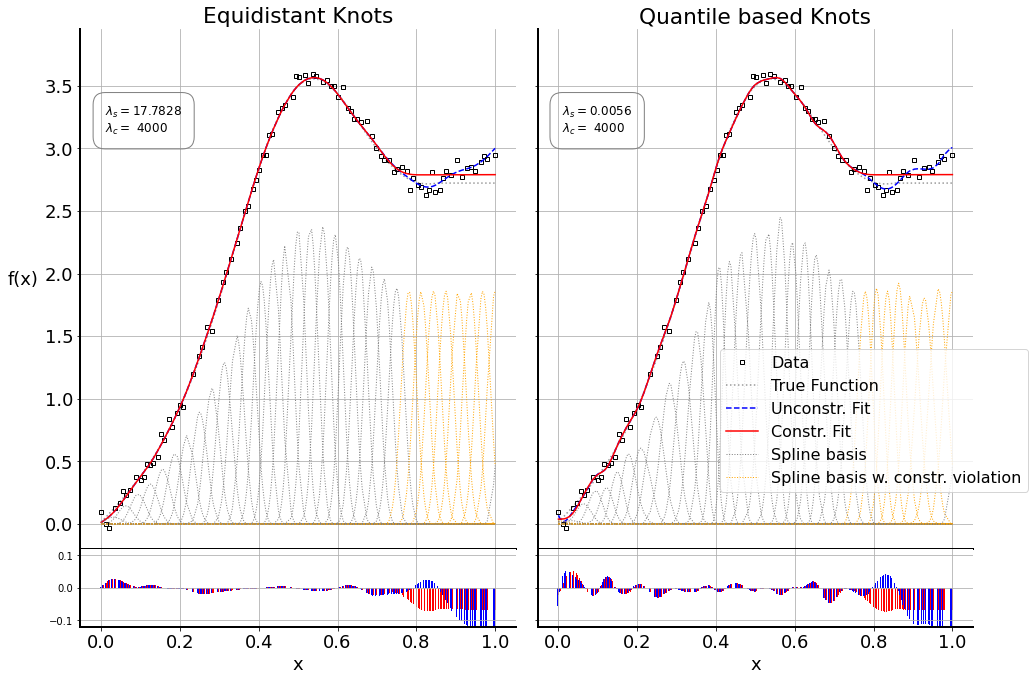

In [75]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex="col", figsize=(16,11),
                        gridspec_kw={"hspace": 0, "height_ratios":[1,0.15], "wspace": 0.05})
ax1, ax2 = axs
ax11, ax12 = ax1
ax21, ax22 = ax2
# remove the tick labels
for ax in axs.ravel():
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

##########################################################################
## plot the data
##########################################################################
ip = 2 if n==250 else 12
##########################################################################
# left plot for equidistant data
ax11.plot(df_train["xlin"][::ip], df_train["ylin"][::ip], color="black", label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax11.plot(df_train["xlin"], df_train["ytrue_lin"], color="black", linestyle=":", alpha=0.4, label="True Function")
ax11.plot(df_train["xlin"], df_train["fit_unc_linspace_equidistant"], color="blue", label="Unconstr. Fit", linestyle="--")
ax11.plot(df_train["xlin"], df_train["fit_con_linspace_equidistant"], color="red", label="Constr. Fit")

ax11.set_title("Equidistant Knots")
               
equidistant_lambda_s = r"$\lambda_s ={}$".format(round(Models_lin[0].smooths["s(1)"].lam["smoothness"], 4))  
equidistant_lambda_c = r"$\lambda_c =$ {}".format(round(Models_lin[0].smooths["s(1)"].lam["constraint"], 1))
ax11.text(x=0.01, y=3.125, s=equidistant_lambda_s+"\n"+equidistant_lambda_c, fontsize=12, color='black', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))
ax11.set_ylabel("f(x)", labelpad=22, rotation=0)
ax11.set_ylim(bottom=-0.2, top=df_train["ylin"].max()*1.1)
# plot basis functions
for i in range(Models_lin[0].basis.shape[1]):
    if ccoef_equidistant[i]:
        ax11.plot(df_train["xlin"], Models_lin[0].basis[:,i]*Models_lin[0].coef_[i], 
                  color="orange", linewidth=1, linestyle=":")
    else:
        ax11.plot(df_train["xlin"], Models_lin[0].basis[:,i]*Models_lin[0].coef_[i], 
                  color="grey", linewidth=1, linestyle=":")
##########################################################################
# right plot for quantile based data
ax12.plot(df_train["xlin"][::ip], df_train["ylin"][::ip], color="black", label="Data", marker="s", markersize=4, markerfacecolor='none', markeredgecolor="black", linewidth=0)
ax12.plot(df_train["xlin"], df_train["ytrue_lin"], color="black", linestyle=":", alpha=0.4, label="True Function")
ax12.plot(df_train["xlin"], df_train["fit_unc_linspace_quantile"], color="blue", label="Unconstr. Fit", linestyle="--")
ax12.plot(df_train["xlin"], df_train["fit_con_linspace_quantile"], color="red", label="Constr. Fit")

quantile_lambda_s = r"$\lambda_s ={}$".format(round(Models_lin[1].smooths["s(1)"].lam["smoothness"], 4))  
quantile_lambda_c = r"$\lambda_c =$ {}".format(round(Models_lin[1].smooths["s(1)"].lam["constraint"], 1))
ax12.text(x=0.009, y=3.125, s=quantile_lambda_s+"\n"+quantile_lambda_c, fontsize=12, color='black', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))
ax12.set_yticklabels([])

ax12.set_title(r"Quantile based Knots")
ax12.set_ylim(bottom=-0.2, top=df_train["ylin"].max()*1.1)
for i in range(Models_lin[1].basis.shape[1]):
    if ccoef_quantile[i]:
        ax12.plot(df_train["xlin"], Models_lin[1].basis[:,i]*Models_lin[1].coef_[i], 
                  color="orange", linewidth=1, linestyle=":")
    else:
        ax12.plot(df_train["xlin"], Models_lin[1].basis[:,i]*Models_lin[1].coef_[i], 
                  color="grey", linewidth=1, linestyle=":")
ax12.plot(0, 0, color="grey", linewidth=1, linestyle=":", label="Spline basis")
ax12.plot(0, 0, color="orange", linewidth=1, linestyle=":", label="Spline basis w. constr. violation")

##########################################################################
## plot the residuals
##########################################################################
res_unc_equi = df_train["ytrue_lin"] - df_train["fit_unc_linspace_equidistant"]
res_con_equi = df_train["ytrue_lin"] - df_train["fit_con_linspace_equidistant"]

res_unc_quant = df_train["ytrue_lin"] - df_train["fit_unc_linspace_quantile"]
res_con_quant = df_train["ytrue_lin"] - df_train["fit_con_linspace_quantile"]

max_ticks = 0.95*max([max(abs(res_unc_equi)), max(abs(res_unc_quant)),  
                     max(abs(res_con_equi)), max(abs(res_con_quant))])
if n == 2500:
    bar_width = 0.001
else:
    bar_width = 0.005

max_ticks = 0.1 
ax21.tick_params(axis='y', labelsize=10)
ax21.set_ylim(bottom=-1.2*max_ticks, top=1.2*max_ticks)
ax21.bar(x=df_train["xlin"]+bar_width/4, color="red", height=res_con_equi, width=bar_width/2)
ax21.bar(x=df_train["xlin"]-bar_width/4, color="blue", height=res_unc_equi, width=bar_width/2)
ax21.set_xlabel("x")

ax22.tick_params(axis='y', labelsize=10)
ax22.set_ylim(bottom=-1.2*max_ticks, top=1.2*max_ticks)
ax22.bar(x=df_train["xlin"]+bar_width/4, color="red", height=res_con_quant, width=bar_width/2)
ax22.bar(x=df_train["xlin"]-bar_width/4, color="blue", height=res_unc_quant, width=bar_width/2)
ax22.set_yticklabels([])
ax22.set_xlabel("x")

ax12.legend(bbox_to_anchor=(0.4, 0.4), loc="upper left", frameon=True, fontsize=16, )
#ax12.legend()

path = "..\\..\\Thesis_WorkingDirectory\\thesisplots\\"
fname = "exp_grid_ndata_"+str(n)+"_rseed_"+str(seed)
print(f"Plot for grid data, {n} data points and seed {seed}")
#fig.savefig(path+"exp_grid\\"+fname+".pdf", transparent=False, bbox_inches='tight')

## **Ebner Data**


In [ ]:
from stareg.star_model import StarModel
from stareg.bspline import Bspline
from stareg.utils import check_constraint
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import numpy as np 
import pandas as pd
import os
from copy import deepcopy

from pyinputplus import inputChoice, inputMenu
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pylab import cm
%matplotlib inline

#mpl.rcParams["font.family"] = "sans-serif"
#mpl.rcParams["font.sans-serif"] = "Computer Modern Sans Serif"
mpl.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["font.size"] = 18
plt.rcParams["axes.linewidth"] = 2

colors = cm.get_cmap("tab10", 10)

# **Get data, normalize and train-test split**

In [148]:
np.random.seed(1)

path = "..\\..\\Data\\"
df = pd.read_csv(filepath_or_buffer=path+"Table_alpha_Data.txt")
df.columns = ["QDot", "T", "HTC"]

df_gridded = pd.read_csv(filepath_or_buffer=path+"Table_alpha_Data_gridded.txt")
df_gridded.columns = ["QDot", "T", "HTC"]

X, y = df[["QDot", "T"]].values, df["HTC"].values
Xgridded, ygridded = df_gridded[["QDot", "T"]].values, df_gridded["HTC"].values

In [158]:
dtype = inputMenu(["gridded", ""], "Which dataset?\n", lettered=True)

if dtype == "gridded":
    X = Xgridded
    y = ygridded
else:
    X = X
    y = y
    
# normalized data
Xmin, Xmax = X.min(axis=0), X.max(axis=0)
Xnorm = (X - Xmin) / (Xmax - Xmin)

cont = True
while cont:
    Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm, y, test_size=0.1)
    print("train test split")
    if np.all(Xtrain.min()) == 0 and np.all(Xtrain.max()) == 1:
        cont = False
        print("finished")
    

Which dataset?
A. gridded
B. 


train test split
finished


In [159]:
def plot_data_hist2d(X, n_bins=10, fname=False):
    fig, ax = plt.subplots(figsize =(10,7))
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    hist, xbins, ybins, _ = ax.hist2d(X[:,0],X[:,1], bins=(nbins,nbins), cmap="OrRd")
    dx = np.diff(xbins).mean()
    dy = np.diff(ybins).mean()
    print("".ljust(50, "="))
    print("dm = ", dx)
    print("dT = ", dy)
    print("".ljust(50, "="))
    for i in range(len(ybins)-1):
        for j in range(len(xbins)-1):
            ax.text(xbins[j]+dx/2,ybins[i]+dy/2, int(hist.T[i,j]), color="k", ha="center", va="center", fontweight="bold")

    ax.set_xlabel(r'$\dot{m}$ [kg/s]', labelpad=1)  
    ax.set_ylabel(r'T[K]', rotation=0, labelpad=24)
    ax.set_xlim(left=X[:,0].min(), right=X[:,0].max())
    ax.set_ylim(bottom=X[:,1].min(), top=X[:,1].max())

    if fname:
        path = '..\\..\\Thesis_WorkingDirectory\\thesisplots\\Ebner\\'
        print(f"Save Figure to {path+fname}")
        plt.savefig(path+fname, transparent=False, bbox_inches='tight')


dm =  0.9671718647654984
dT =  49.7023
Save Figure to ..\..\Thesis_WorkingDirectory\thesisplots\Ebner\data_distribution.png


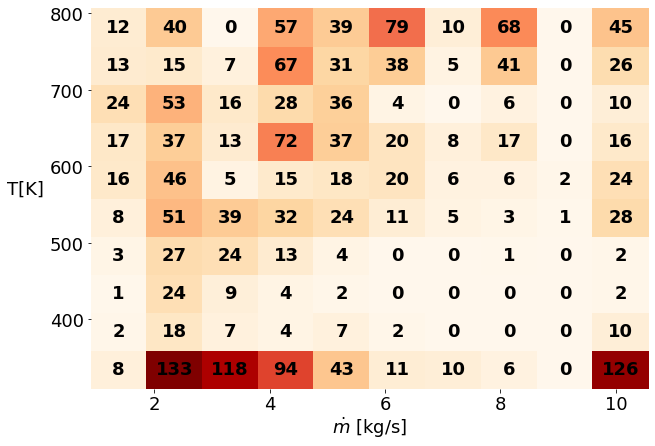

In [76]:
# Plot histogram of data
plot_data_hist2d(X=X, n_bins=10, fname="data_distribution.png")

# **Create a model and train it**

In [151]:
# create the two submodels    
knot_type = inputMenu(["quantile", "equidistant"], prompt="Specify knot placement type\n", lettered=True)
m1 = ( ("s(1)", "inc", 50, (1, 0), knot_type),)
m2 = ( ("s(1)", "peak", 50, (1, 0), knot_type),)
m3 = ( ("t(1,2)", "none", (10,10), (1, 0), knot_type), )

M1 = StarModel(description=m1)
M2 = StarModel(description=m2)
M3 = StarModel(description=m3)

Specify knot placement type
A. quantile
B. equidistant


 equidistant


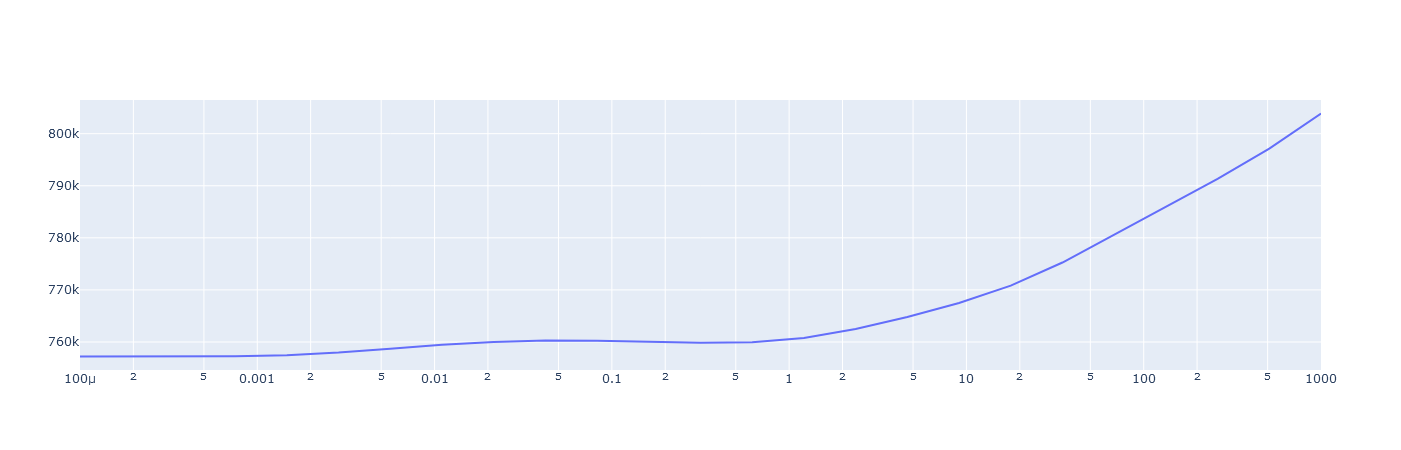

{'s(1)': {'constraint': 'inc',
          'knot_type': 'equidistant',
          'lam': {'constraint': 0.3831186849557289,
                  'smoothness': 0.0003831186849557289},
          'n_param': 50}}


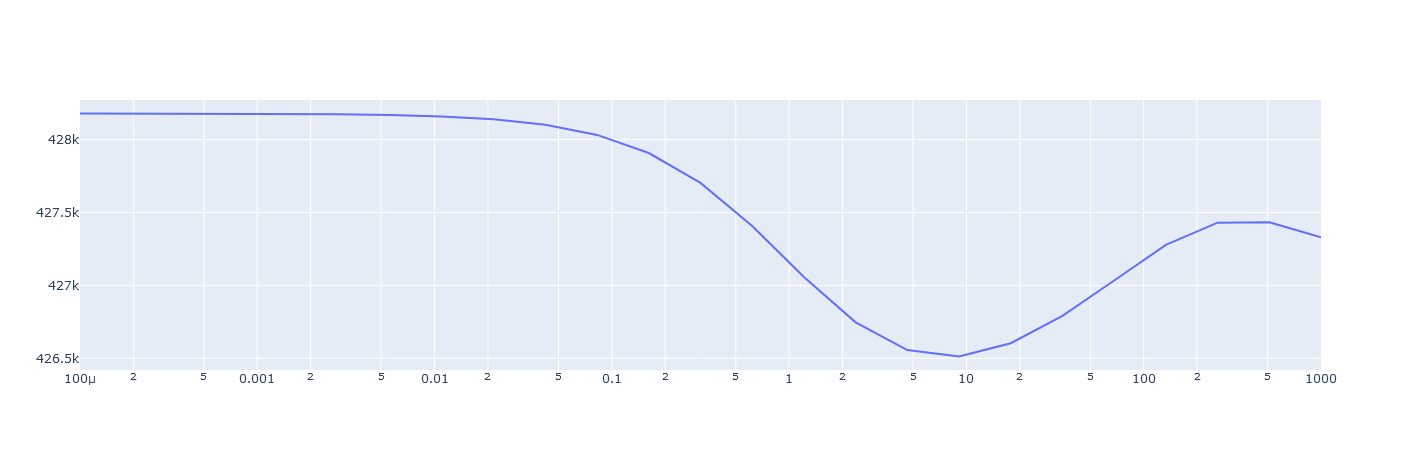

{'s(1)': {'constraint': 'peak',
          'knot_type': 'equidistant',
          'lam': {'constraint': 9085.175756516881,
                  'smoothness': 9.08517575651688},
          'n_param': 50}}


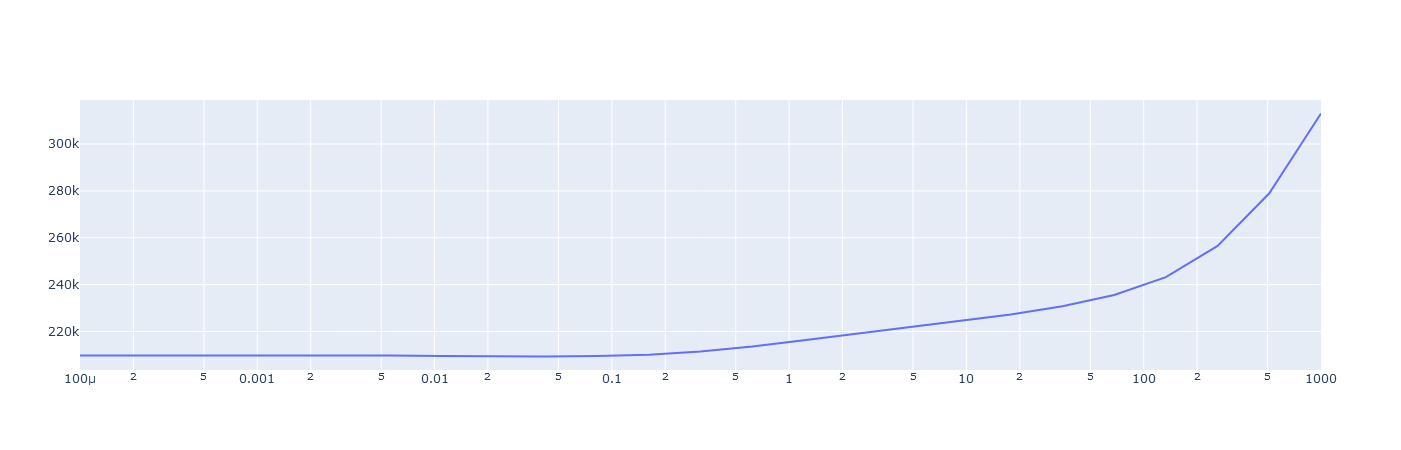

{'t(1,2)': {'constraint': 'none',
            'knot_type': 'equidistant',
            'lam': {'constraint': 42.169650342858226,
                    'smoothness': 0.042169650342858224},
            'n_param': (10, 10)}}


In [152]:
# get the optimal smoothing parameters
M1.GCV_smoothingParameter(X=Xtrain[:,0].reshape(-1,1), y=ytrain, n_grid=25)
M1.plot_GCV_curve()
print(M1)
M2.GCV_smoothingParameter(X=Xtrain[:,1].reshape(-1,1), y=ytrain, n_grid=25)
M2.plot_GCV_curve()
print(M2)
M3.GCV_smoothingParameter(X=Xtrain, y=ytrain, n_grid=25)
M3.plot_GCV_curve()
print(M3)

**The optimal smoothing parameters are kind of garbage because of the data**

In [165]:
ytrain.max(axis=0)

6853.696237004486

Nr of predictions smaller than zero before iteration 0: 80
Nr of predictions smaller than zero before iteration 1: 50
Nr of predictions smaller than zero before iteration 2: 175
Nr of predictions smaller than zero before iteration 3: 130
Nr of predictions smaller than zero before iteration 4: 79
Nr of predictions smaller than zero before iteration 5: 100
Nr of predictions smaller than zero before iteration 6: 94
Nr of predictions smaller than zero before iteration 7: 72
Nr of predictions smaller than zero before iteration 8: 87
Nr of predictions smaller than zero before iteration 9: 115
===============================Constraint Model:================================ 
 {'s(1)': {'constraint': 'inc',
          'knot_type': 'equidistant',
          'lam': {'constraint': 3831.1868495572894,
                  'smoothness': 383.1186849557289},
          'n_param': 50},
 's(2)': {'constraint': 'peak',
          'knot_type': 'equidistant',
          'lam': {'constraint': 9085.175756516881,
   

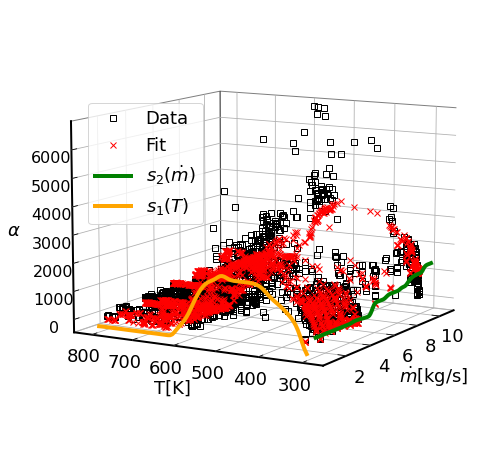

In [204]:
# create a combined model and train it
m = ( ("s(1)", "inc", 50, (1000000*M1.description_dict["s(1)"]["lam"]["smoothness"], 10000*M1.description_dict["s(1)"]["lam"]["constraint"]), knot_type), 
      ("s(2)", "peak", 50, (100*M2.description_dict["s(1)"]["lam"]["smoothness"], 1*M2.description_dict["s(1)"]["lam"]["constraint"]), knot_type), )
      
mgridded = ( ("s(1)", "inc", 50, (M1.description_dict["s(1)"]["lam"]["smoothness"], M1.description_dict["s(1)"]["lam"]["constraint"]), knot_type), 
             ("s(2)", "peak", 50, (M2.description_dict["s(1)"]["lam"]["smoothness"], M2.description_dict["s(1)"]["lam"]["constraint"]), knot_type), )
if dtype == "gridded":
    m = mgridded
M = StarModel(description=m)
M.fit(X=Xtrain, y=ytrain, plot_=False, global_pos=True)
ypred = M.predict(X=Xtest)
print("Constraint Model:".center(80, "="), "\n", M)
plot_model(Mod=M, partition=1, fname="Model_constraint_lam_s1_383_lam_s2_908.pdf")


Nr of predictions smaller than zero before iteration 0: 80
Nr of predictions smaller than zero before iteration 1: 58
Nr of predictions smaller than zero before iteration 2: 33
Nr of predictions smaller than zero before iteration 3: 25
Nr of predictions smaller than zero before iteration 4: 38
Nr of predictions smaller than zero before iteration 5: 17
Nr of predictions smaller than zero before iteration 6: 20
Nr of predictions smaller than zero before iteration 7: 22
Nr of predictions smaller than zero before iteration 8: 39
Nr of predictions smaller than zero before iteration 9: 33
==============================Unconstraint Model:=============================== 
 {'s(1)': {'constraint': 'inc',
          'knot_type': 'equidistant',
          'lam': {'constraint': 0, 'smoothness': 383.1186849557289},
          'n_param': 50},
 's(2)': {'constraint': 'peak',
          'knot_type': 'equidistant',
          'lam': {'constraint': 0, 'smoothness': 908.517575651688},
          'n_param': 50}}

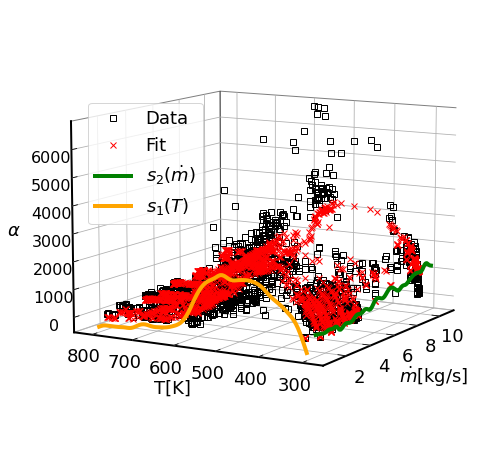

In [205]:
# create the unconstraint model
m_unconstraint = ( ("s(1)", "inc", 50, (1000000*M1.description_dict["s(1)"]["lam"]["smoothness"], 0), knot_type), 
                   ("s(2)", "peak", 50, (100*M2.description_dict["s(1)"]["lam"]["smoothness"], 0), knot_type), )
      

mgridded_unc = ( ("s(1)", "inc", 50, (M1.description_dict["s(1)"]["lam"]["smoothness"], 0), knot_type), 
                 ("s(2)", "peak", 50,(M2.description_dict["s(1)"]["lam"]["smoothness"], 0), knot_type), )
if dtype == "gridded":
    m_unconstraint = mgridded_unc
M_unconstraint = StarModel(description=m_unconstraint)
M_unconstraint.fit(X=Xtrain, y=ytrain, plot_=False, global_pos=True)
ypred_unconstraint = M_unconstraint.predict(X=Xtest)
print("Unconstraint Model:".center(80, "="), "\n", M_unconstraint)
plot_model(Mod=M_unconstraint, partition=1, fname="Model_unc_lam_s1_383_lam_s2_908.pdf")


In [175]:
print("MSEs and AIC for Ebner Data".center(100, "="))
print("MSE on Train Set".center(80, "="))
print("Constraint Model =".ljust(30), mean_squared_error(M.basis@M.coef_, ytrain))
print("Unconstraint Model =".ljust(30), mean_squared_error(M_unconstraint.basis@M_unconstraint.coef_, ytrain))
print("MSE on Test Set".center(80, "="))
print("Constraint Model =".ljust(30), mean_squared_error(ypred, ytest))
print("Unconstraint Model =".ljust(30), mean_squared_error(ypred_unconstraint, ytest))
print("AIC".center(80, "="))
print("Constraint Model: ".ljust(30), AIC(model=M, ytest=ytest, Xtest=Xtest))
print("Unconstraint Model: ".ljust(30), AIC(model=M_unconstraint, ytest=ytest, Xtest=Xtest))

====================================MSEs and AIC for Ebner Data=====================================
================================MSE on Train Set================================
Constraint Model =             1516138.7206369338
Unconstraint Model =           1517828.4065678373
================================MSE on Test Set=================================
Constraint Model =             1380793.5566094357
Unconstraint Model =           1384261.2443448359
======================================AIC=======================================
Constraint Model:              2723.94637350857
Unconstraint Model:            2748.5333645761134


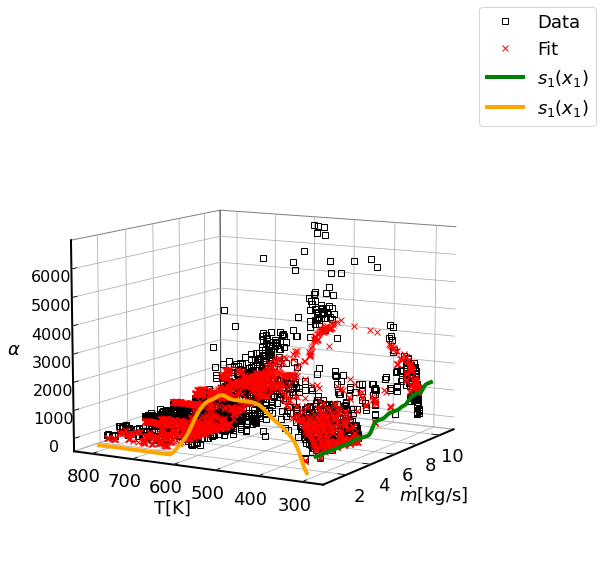

In [202]:
def plot_model(Mod, partition=True, fname=False):
    fig = plt.figure(figsize=(14,8))
    ax = fig.gca(projection='3d')

    ax.grid(True)
    ax.xaxis.pane.set_edgecolor("black")
    ax.yaxis.pane.set_edgecolor("black")
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis._axinfo["tick"]["inward_factor"] = 0
    ax.xaxis._axinfo["tick"]["outward_factor"] = 0.4
    ax.yaxis._axinfo["tick"]["inward_factor"] = 0
    ax.yaxis._axinfo["tick"]["outward_factor"] = 0.4

    ax.zaxis._axinfo["tick"]["inward_factor"] = 0
    ax.zaxis._axinfo["tick"]["outward_factor"] = 0
    ax.zaxis._axinfo["tick"]["outward_factor"] = 0.4

    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(100))
    ax.zaxis.set_major_locator(MultipleLocator(1000))

    # plot the fit
    ax.plot(xs=Xmin[0] + Xtrain[:,0]*(Xmax[0]-Xmin[0]), ys=Xmin[1]+Xtrain[:,1]*(Xmax[1]-Xmin[1]), zs=ytrain, marker="s", 
            label="Data", color="black", markersize=6, markerfacecolor='none', markeredgecolor="black", linewidth=0)
    ax.plot(xs=Xmin[0] + Xtrain[:,0]*(Xmax[0]-Xmin[0]), ys=Xmin[1]+Xtrain[:,1]*(Xmax[1]-Xmin[1]), zs=Mod.basis@Mod.coef_, 
            label="Fit", marker="x", color="red", markersize=6, markerfacecolor='none', markeredgecolor="red", linewidth=0)
    
    if partition:
        # plot the individual parts of the fit
        xplot_m, xplot_T = np.linspace(0,1,100), np.linspace(0,1,100)
        B_T, B_m = Bspline(), Bspline()
        B_T.bspline_basis(x_data=xplot_T, k=Mod.smooths["s(1)"].n_param)
        B_m.bspline_basis(x_data=xplot_m, k=Mod.smooths["s(2)"].n_param)
        s1 = B_m.basis @ Mod.smooths["s(1)"].coef_
        s2 = B_T.basis @ Mod.smooths["s(2)"].coef_
        ax.plot(xs=Xmin[0]+xplot_m*(Xmax[0] - Xmin[0]), ys=np.ones(100)*(Xmin[1]-20), zs=s1, linewidth=4, label=r"$s_2(\dot m)$", color="green")
        ax.plot(xs=np.ones(100)*Xmin[0], ys=Xmin[1]+xplot_T*(Xmax[1]-Xmin[1]), zs=s2, linewidth=4, label=r"$s_1(T)$", color="orange")

    ax.xaxis.set_rotate_label(False)
    ax.set_xlabel(r"$\dot{m}$[kg/s]", labelpad=16, rotation=0)
    ax.yaxis.set_rotate_label(False)
    ax.set_ylabel(r"T[K]", labelpad=12, rotation=0)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(r"$\alpha$", labelpad=12, rotation=0)
    ax.zaxis.set_tick_params(labelsize=16)
    
    ax.view_init(elev=10, azim=100+110)
    
    ax.legend(loc=(0.1,0.5))
    
    if fname: 
        path = '..\\..\\Thesis_WorkingDirectory\\thesisplots\\Ebner\\'
        print(f"Save Figure to {path+fname}")
        plt.savefig(path+fname, transparent=False, bbox_inches='tight')


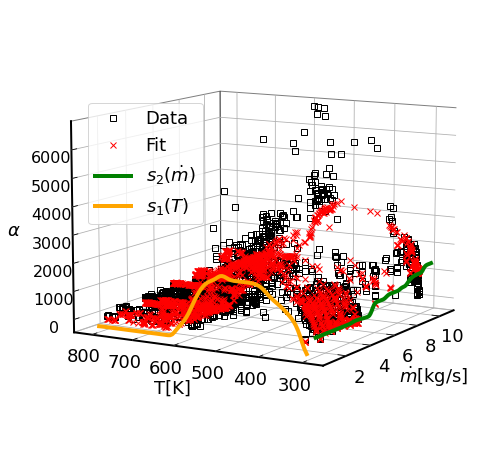

In [203]:
plot_model(M, partition=True)

In [22]:
def plot_model_plotly(Mod):
    fig = make_subplots(rows=1, cols=2, 
                        specs=[[{"type": "scene"}, {"type": "scene"}]])
    #fig.add_trace(go.Surface(x=xgrid, y=ygrid, z=zgrid))
    fig.add_trace(go.Scatter3d(x=Xtrain[:,0], y=Xtrain[:,1], z=ytrain, mode="markers", marker=dict(size=2, color="black", symbol="x"), name="data"), row=1, col=1)
    fig.add_trace(go.Scatter3d(x=Xtrain[:,0], y=Xtrain[:,1], z=Mod.basis @ Mod.coef_, mode="markers", marker=dict(size=2, color="red"), name="fit"), row=1, col=1)
    fig.update_layout(xaxis_title="QDot",
                      yaxis_title="T",
                      font=dict(size=18,color="black"))
    fig.layout.legend.itemsizing = "constant"

    # plot individual parts
    
    #z_s1 = Mod.smooths["s(1)"].basis @ Mod.smooths["s(1)"].coef_
    #z_s2 = Mod.smooths["s(2)"].basis @ Mod.smooths["s(2)"].coef_
    #z_t12 = Mod.smooths["t(1,2)"].basis @ Mod.smooths["t(1,2)"].coef_
    
    for smooth in Mod.smooths.keys():
        z = Mod.smooths[smooth].basis @ Mod.smooths[smooth].coef_
        fig.add_trace(go.Scatter3d(x=Xtrain[:,0], y=Xtrain[:,1], z=z, mode="markers", marker=dict(size=2), name=smooth), row=1, col=2)
 
    fig.update_layout(xaxis_title="QDot",
                      yaxis_title="T",
                      font=dict(size=18,color="black"))
    fig.layout.legend.itemsizing = "constant"
    fig.update_layout(height=700, width=1000)
    #fig.write_html("img/Fit_partition.html")
    fig.show()

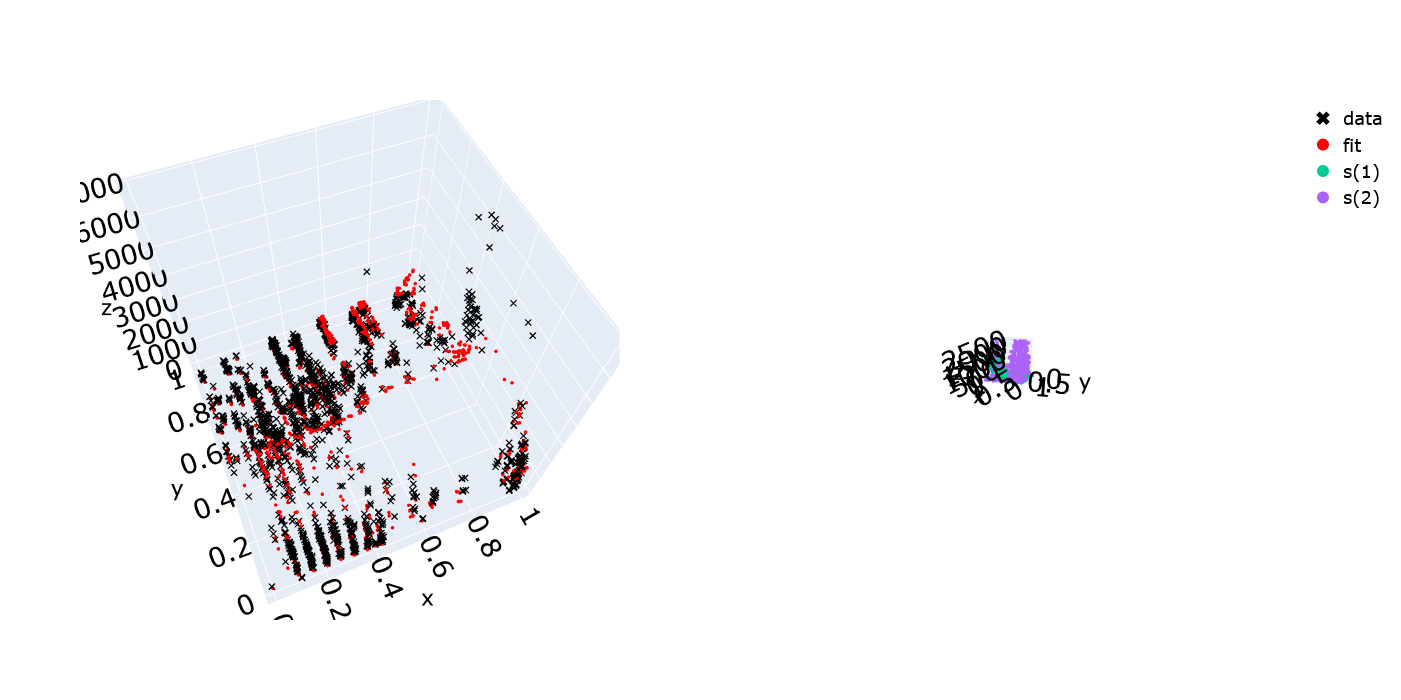

In [23]:
plot_model_plotly(M)

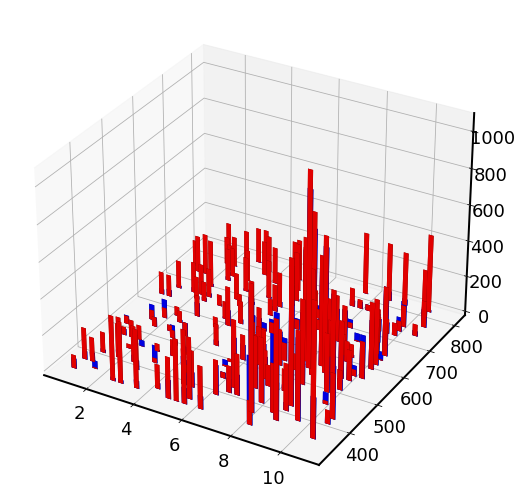

In [63]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111, projection='3d')

res = abs(ytest - ypred)
res_unc = abs(ytest - ypred_unconstraint)
ax1.bar3d(x=Xmin[0]+Xtest[:,0]*(Xmax[0]-Xmin[0]), y=Xmin[1]+Xtest[:,1]*(Xmax[1]-Xmin[1]), z=np.zeros(Xtest.shape[0]), dx=0.2, dy=0.2, dz=res, color="red")
ax1.bar3d(x=Xmin[0] + (Xtest[:,0])*(Xmax[0]-Xmin[0]), y=Xmin[1]+(Xtest[:,1])*(Xmax[1]-Xmin[1]), z=np.zeros(Xtest.shape[0]), dx=0.22, dy=0.22, dz=res_unc, color="blue")

plt.show()